<h1 style="font-size:3em; text-align: center">Using Uncertainty and Gaussian Distributions to Replace Custom Loss</h1>

Instead of using a custom loss function that penalizes over-estimates of the true value, we will use a very accurate neural network and a Gaussian distribution to choose the lower percentiles of the predictions rather than the average prediction (which will try to get as close to the true value as possible). This way, we can select what number in the uncertainty will be used in the real world application.

In [1]:
# imports
import numpy             as np
import matplotlib.pyplot as plt
import pandas            as pd
import math
import keras
from scipy.stats  import norm
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras        import backend as K
from datetime     import datetime
from keras.optimizers      import RMSprop
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics       import mean_squared_error
from matplotlib.pylab      import rcParams
%matplotlib inline
rcParams['figure.figsize'] = 15, 6

# number of inputs to be fed
look_back = 288
# number of outputs to be generated
look_forward = 24

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1, look_forward=2):
    dataX, dataY = [], []
    np.array(dataY)
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back),0]
        if len(dataset[i + look_back:i+look_back+look_forward, 0]) == look_forward:
            dataX.append(a)
            dataY.append(dataset[i + look_back:i+look_back+look_forward, 0])
    return np.array(dataX), np.array(dataY)

def predict_with_uncertainty(model, dataset, n_iter=100):
    # This function activates drop-out when doing predictions
    f = K.function([model.layers[0].input, K.learning_phase()],
                      [model.layers[-1].output])
    all_pred = np.zeros((n_iter,) + (1,look_forward,))
    for iter in range(n_iter):
        all_pred[iter] = f([dataset, 1])
    avg_pred = all_pred.mean(axis=0)
    std = np.std(all_pred, axis=0)
    return all_pred, avg_pred, std

# given a model and data from the original dataset, it uses predict_with_uncertainty to 
def run_predictions (model, dataset):
    # normalizes the dataset and prepares it to be fed to the model
    dataset = np.array(dataset).transpose().reshape(-1, 1)
    dataset = scaler.fit_transform(dataset).transpose()
    data = (dataset.T)
    data = data.reshape(1, 1, data.shape[0])
    # feeds the model and data into a function that will activate the dro-out
    all_pred, avg_pred, std = predict_with_uncertainty(model, data)
    
    # All the predictions
    all_pred = scaler.inverse_transform(all_pred.reshape(all_pred.shape[0], all_pred.shape[-1]))
    # The Average Prediction
    avg_pred = scaler.inverse_transform(avg_pred)
    # The Standard Deviation At Each T Of Prediction
    std = scaler.inverse_transform(std)
    
    return all_pred, avg_pred, std


Using TensorFlow backend.


In [13]:
def predict (model, day=11, total_days=1, delta=1, show_gradual_error=False, show_graph=True):
    # creates matrices to hold the 
    avg_preds = np.zeros((288*total_days/delta, look_forward))
    true_vals = np.zeros((288*total_days/delta, look_forward))
    cdf_vals  = np.zeros((288*total_days/delta, look_forward))
    
    percent_over = np.zeros(288*total_days/delta)
    # Runs all the predictions
    for i in range (288*total_days/delta):
        # the point where the model will predict
        point = 288*day + i * delta
        
        # Gets predictions
        all_pred, avg_pred, std = run_predictions (model, dataset_orig[point-look_back:point].reshape(look_back))
        
        # Reshapes all of the things
        true_val = dataset_orig[point:point+look_forward].reshape(look_forward)
        avg_pred = avg_pred.reshape(look_forward)
        std = std.reshape(look_forward)
        
        percent_over[i] = 100.0 * (np.ones((len(all_pred),1) )*true_val - all_pred < 0).sum() / all_pred.size
        
        # converts the original values to cdf values according to the cumullative distibution functions at t+1, t+2, ..., t+24 (0.0-1.0)
        # Adds the values to the overall matrix of cdf
        cdf_vals[i,:] = norm.cdf(true_val, loc=avg_pred, scale=std)
        
        avg_preds[i], true_vals[i] = avg_pred, true_val
        
        if(show_graph):
            # plots the uncertainty to the degree of half a standard deviation
            plt.fill_between(range(point, point+look_forward), 
                             avg_pred + std/2.0, 
                             avg_pred - std/2.0, 
                             facecolor='red', alpha=0.25)

            # plots the uncertainty to the degree of a full standard deviation
            plt.fill_between(range(point, point+look_forward), 
                             avg_pred + std, 
                             avg_pred - std, 
                             facecolor='red', alpha=0.25)
        
            # plots the average predictions
            plt.plot(range(point, point+look_forward), avg_pred, color='red', alpha=1)
    
    print "Percent Overestimating: {}".format(np.mean(percent_over))
    
    if show_graph:
        plt.plot( np.arange(288*total_days+look_forward) + 288 * day, dataset_orig[288*day:288*day+288*total_days + look_forward,0])
        plt.axhline(0)
        plt.show()
    
    if show_gradual_error:
        indiv_err = true_vals - avg_preds
        for i in range(look_forward):
            plt.scatter(np.ones(len(indiv_err[:,i]))*i,indiv_err[:,i], color='black',alpha=0.1)
        plt.axhline(0)
        plt.show()
    return cdf_vals

In [3]:
# The interval between each dataset (original data in 5 minute intervals)
time_grouping = '5min'

# load the dataset
dataframe = pd.read_csv('ignored_assets/paxout_table.csv', engine='python', nrows=288*21)
dataframe['time_bucket'] = pd.to_datetime(dataframe['time_bucket'])
dataframe = dataframe.set_index('time_bucket')
dataframe['total'] = dataframe.sum(axis=1)
dataframe['day_hour'] = dataframe.index.round(time_grouping)

# The data set with the sum of all the cars out at the 
dataframe = dataframe[['total','day_hour']].groupby('day_hour').sum()

dataset_orig = dataframe.values
dataset_orig = dataset_orig.astype('float32')

# scale the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset_orig)

# split into train and test sets
train_size = 288*10
test_size = len(dataset) - train_size
test, train = dataset[0:test_size,:], dataset[test_size:len(dataset)-look_forward,:]

# reshape into X=[t, t-1, t-2,..., t-look_back] and Y=[t+1, t+2,... t+look_forward]
trainX, trainY = create_dataset(train, look_back, look_forward)
testX, testY = create_dataset(test, look_back, look_forward)
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [15]:
# creates a model but does not compile the model
def create_model(rate = 0.2):
    model = Sequential()
    model.add(Dropout(rate, input_shape=(1, look_back)))
    lstm = LSTM(256, recurrent_dropout=0.3)
    model.add(lstm)
    model.add(Dropout(rate))
    model.add(Dense(128))
    model.add(Dropout(rate))
    model.add(Dense(128))
    model.add(Dropout(rate))
    model.add(Dense(128))
    model.add(Dense(look_forward))
    return model

Epoch 1/5
2s - loss: 0.0229
Epoch 2/5
2s - loss: 0.0099
Epoch 3/5
2s - loss: 0.0079
Epoch 4/5
2s - loss: 0.0072
Epoch 5/5
2s - loss: 0.0064
Epoch 1/1
Epoch 1/1
Epoch 1/1
Epoch 1/1
Epoch 1/1
Epoch 1/1
Epoch 1/1
Epoch 1/1
Epoch 1/1
Epoch 1/1
2s - loss: 0.0047
Epoch 1/1
Epoch 1/1
Epoch 1/1
Epoch 1/1
Epoch 1/1
Epoch 1/1
Epoch 1/1
Epoch 1/1
Epoch 1/1
Epoch 1/1
2s - loss: 0.0043
Epoch 1/1
Epoch 1/1
Epoch 1/1
Epoch 1/1
Epoch 1/1
Epoch 1/1
Epoch 1/1
Epoch 1/1
Epoch 1/1
Epoch 1/1
2s - loss: 0.0040
Percent Overestimating: 52.3472222222


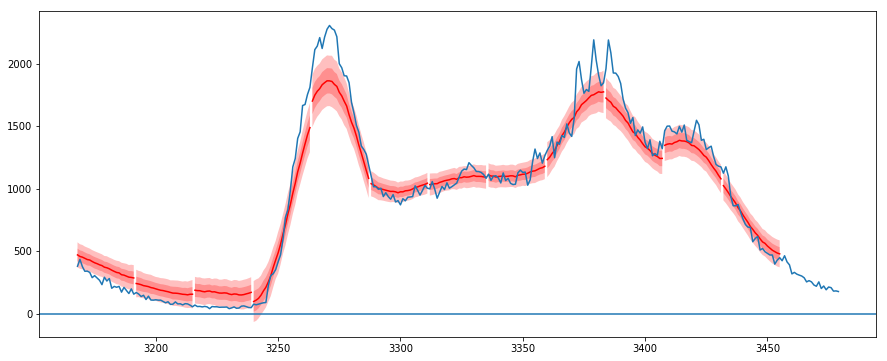

Epoch 1/5
2s - loss: 0.0288
Epoch 2/5
2s - loss: 0.0119
Epoch 3/5
2s - loss: 0.0095
Epoch 4/5
2s - loss: 0.0088
Epoch 5/5
2s - loss: 0.0078
Epoch 1/1
Epoch 1/1
Epoch 1/1
Epoch 1/1
Epoch 1/1
Epoch 1/1
Epoch 1/1
Epoch 1/1
Epoch 1/1
Epoch 1/1
2s - loss: 0.0053
Epoch 1/1
Epoch 1/1
Epoch 1/1
Epoch 1/1
Epoch 1/1
Epoch 1/1
Epoch 1/1
Epoch 1/1
Epoch 1/1
Epoch 1/1
2s - loss: 0.0047
Epoch 1/1
Epoch 1/1
Epoch 1/1
Epoch 1/1
Epoch 1/1
Epoch 1/1
Epoch 1/1
Epoch 1/1
Epoch 1/1
Epoch 1/1
2s - loss: 0.0045
Percent Overestimating: 50.8402777778


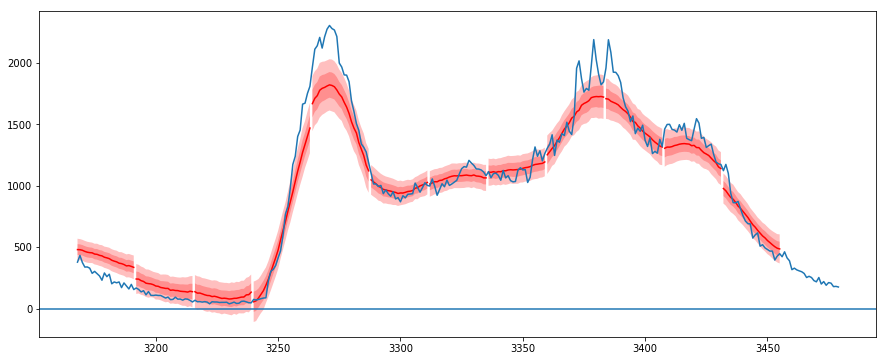

array([[ 0.1237492 ,  0.29716787,  0.1213521 ,  0.06883873,  0.07984281,
         0.06759676,  0.02209365,  0.0474204 ,  0.03523562,  0.02524573,
         0.0113413 ,  0.06956138,  0.04041098,  0.07774917,  0.0164494 ,
         0.0298344 ,  0.03068039,  0.04526592,  0.01801861,  0.05106013,
         0.04068826,  0.02306171,  0.06081448,  0.03051786],
       [ 0.27351579,  0.23595594,  0.21273671,  0.2547507 ,  0.19875527,
         0.28688944,  0.1941222 ,  0.20120591,  0.25100347,  0.24472691,
         0.26638626,  0.25340381,  0.24397016,  0.26026073,  0.24379613,
         0.24165282,  0.3097046 ,  0.25750788,  0.28377256,  0.27217191,
         0.30406126,  0.31856869,  0.27097021,  0.25559512],
       [ 0.30339168,  0.30467894,  0.29943634,  0.30172513,  0.33750446,
         0.34198716,  0.30148761,  0.37408011,  0.36003826,  0.37655052,
         0.38000158,  0.40277375,  0.39316992,  0.40531862,  0.37981044,
         0.39800197,  0.40379601,  0.37615453,  0.3614291 ,  0.39672617,
  

In [16]:
batch = 5
seed = 11
# create and fit the LSTM network
model = create_model(rate=0.2)
model2 = create_model(rate=0.2)

np.random.seed(seed)
model.compile(loss='mean_squared_error', optimizer=RMSprop(lr=0.0002, rho=0.9, epsilon=1e-08, decay=0.0002))
model.fit(trainX, trainY, epochs=5, batch_size=batch, verbose=2)
for i in range (30):
    if i % 10 == 9:
        model.fit(trainX, trainY, epochs=1, batch_size=batch, verbose=2)
    else:
        model.fit(trainX, trainY, epochs=1, batch_size=batch, verbose=3)
predict(model, total_days=1,day=11,delta=24)

np.random.seed(seed)
model2.compile(loss='mean_squared_error', optimizer=RMSprop(lr=0.0001, rho=0.9, epsilon=1e-08, decay=0.0002))
model2.fit(trainX, trainY, epochs=5, batch_size=batch, verbose=2)
for i in range (30):
    if i % 10 == 9:
        model2.fit(trainX, trainY, epochs=1, batch_size=batch, verbose=2)
    else:
        model2.fit(trainX, trainY, epochs=1, batch_size=batch, verbose=3)
x = predict(model2, total_days=1,day=11,delta=24)


Percent Overestimating: 49.4143518519


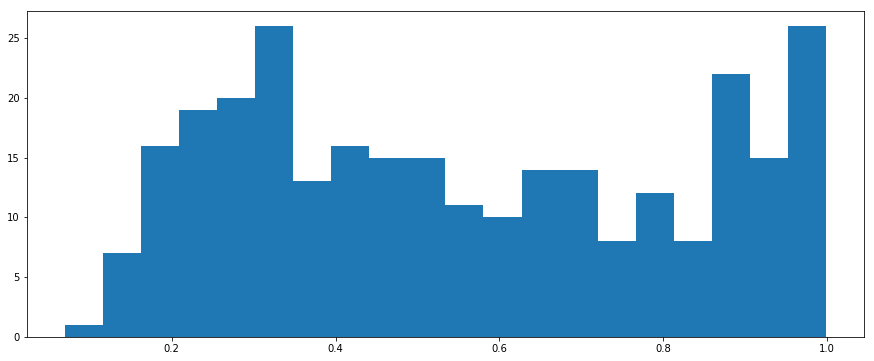

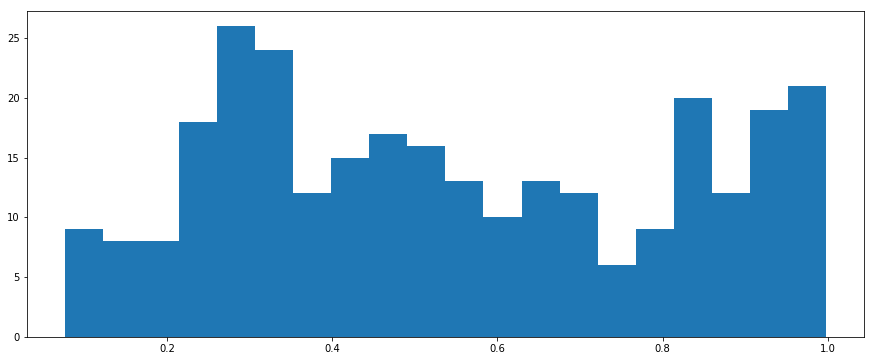

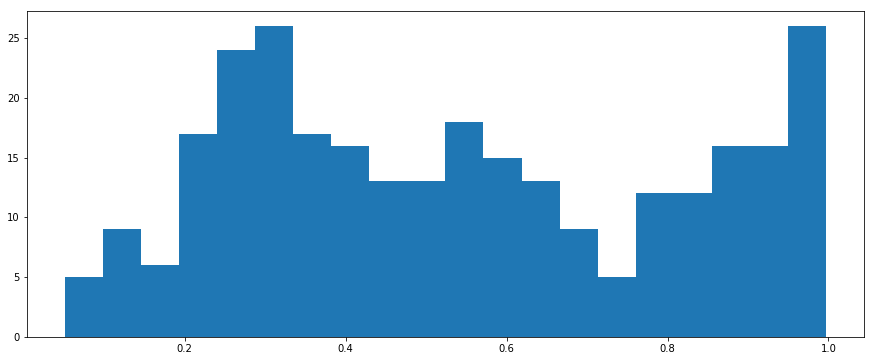

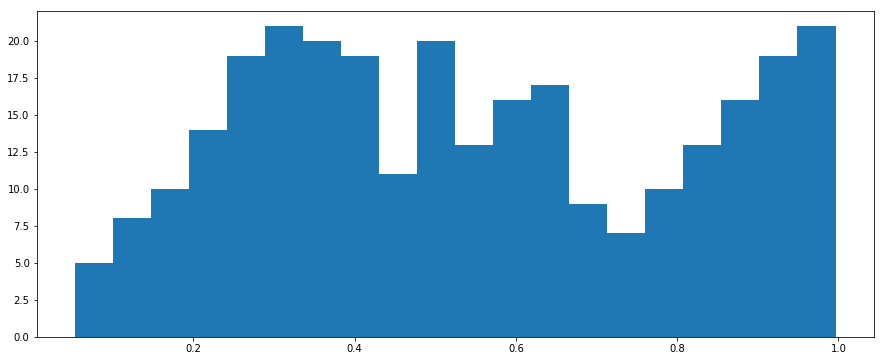

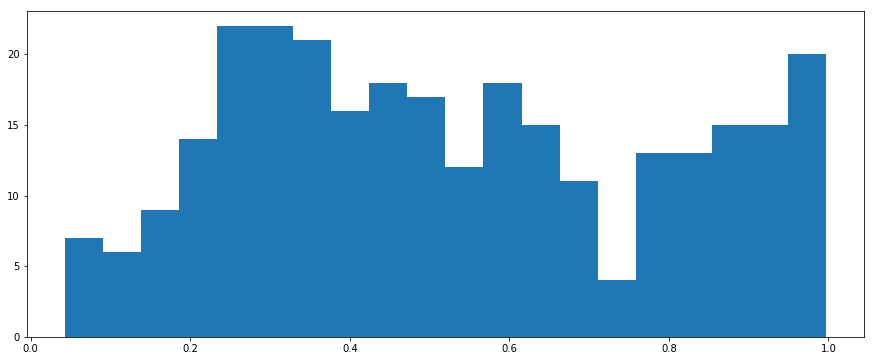

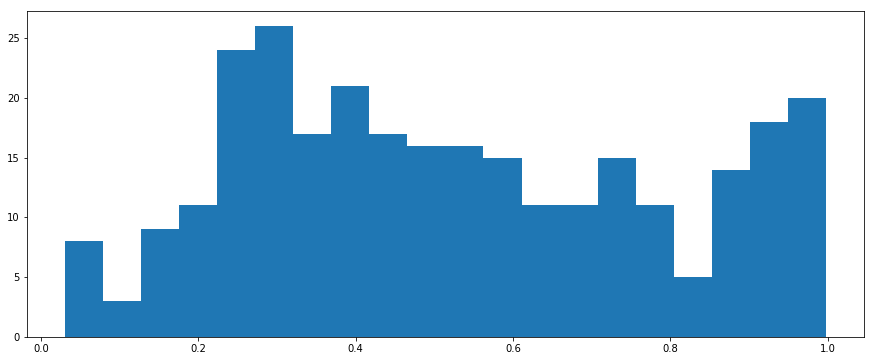

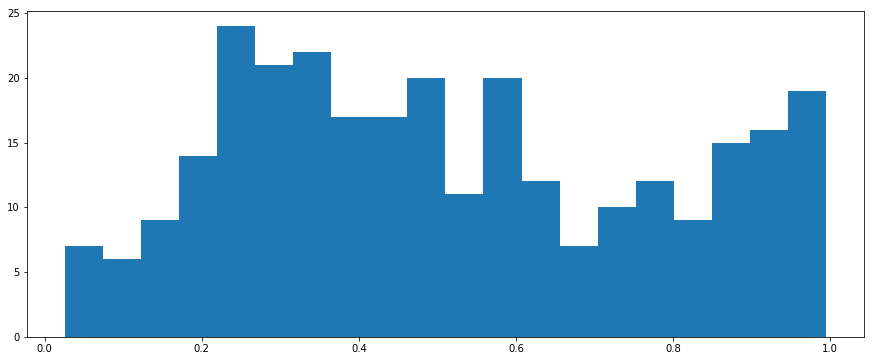

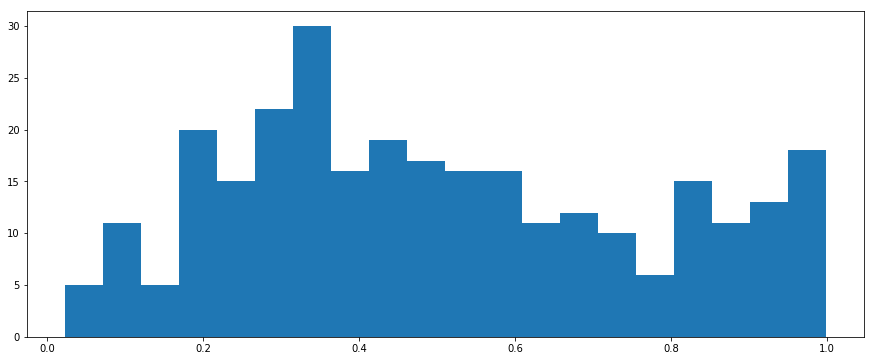

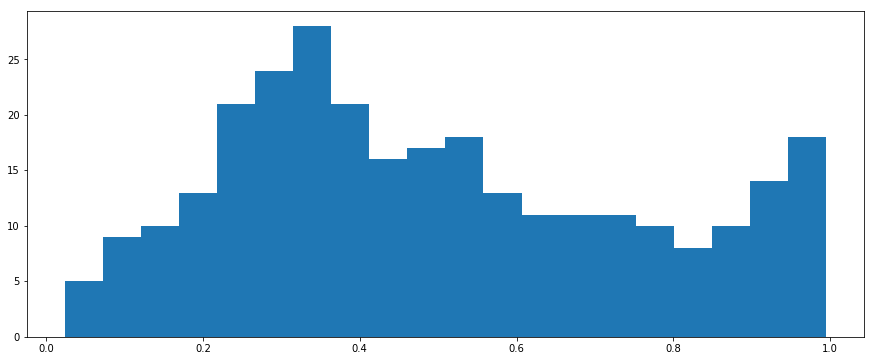

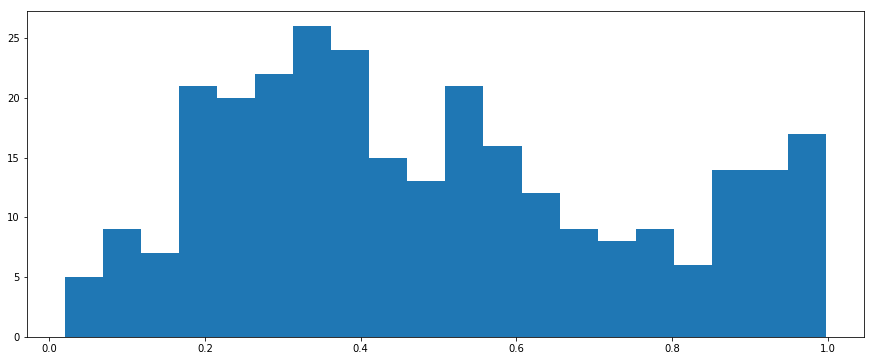

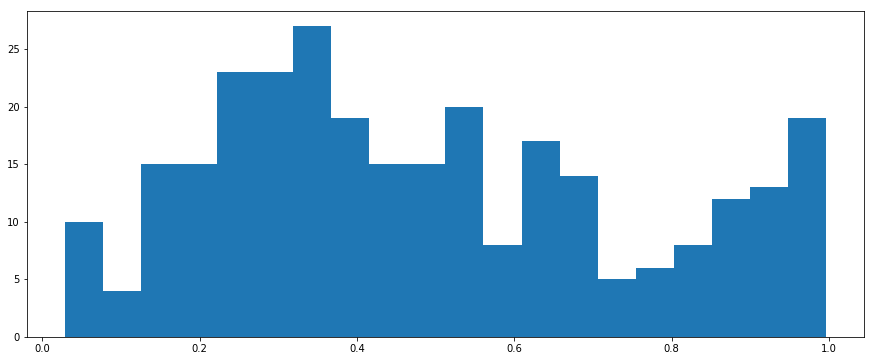

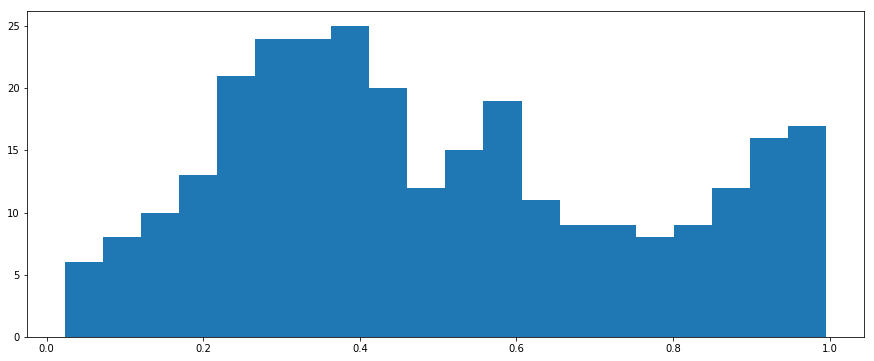

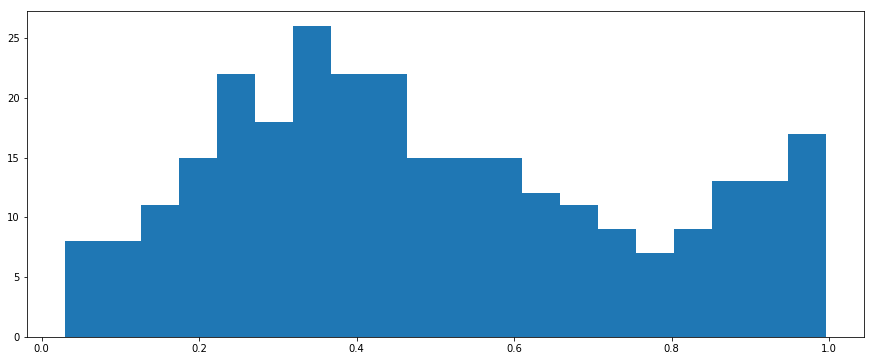

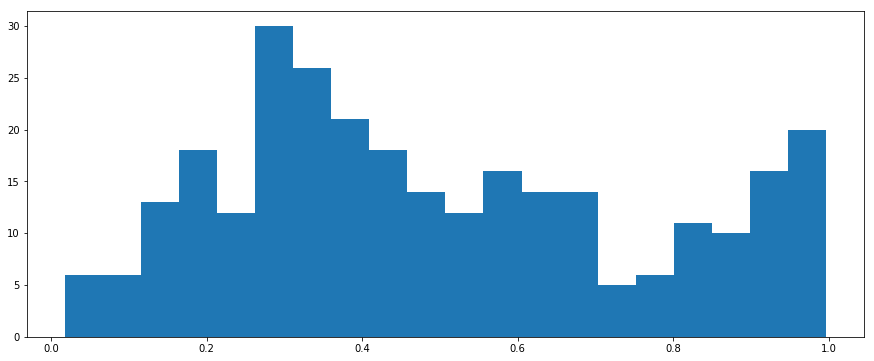

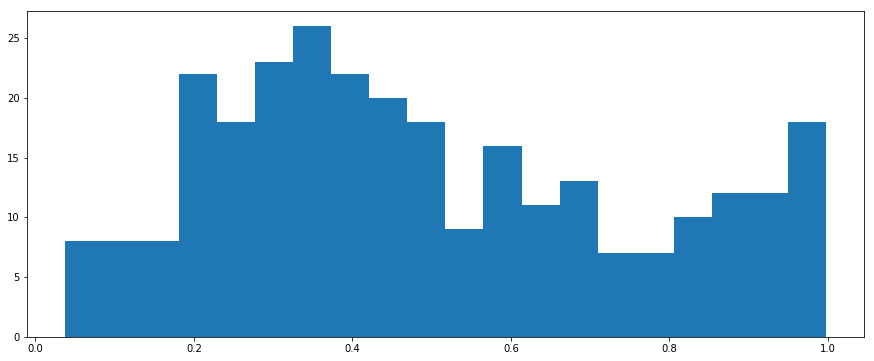

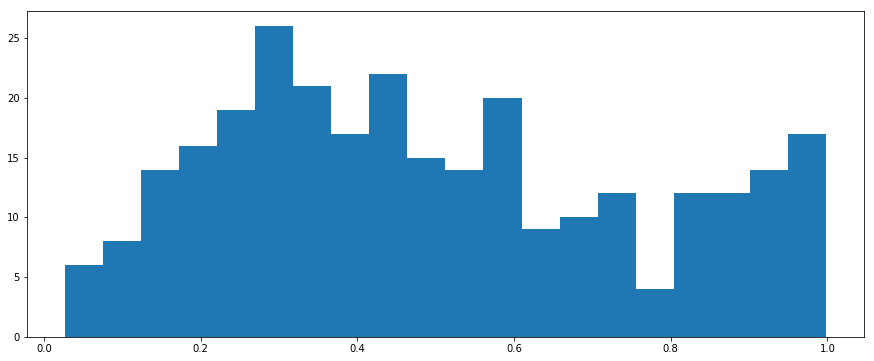

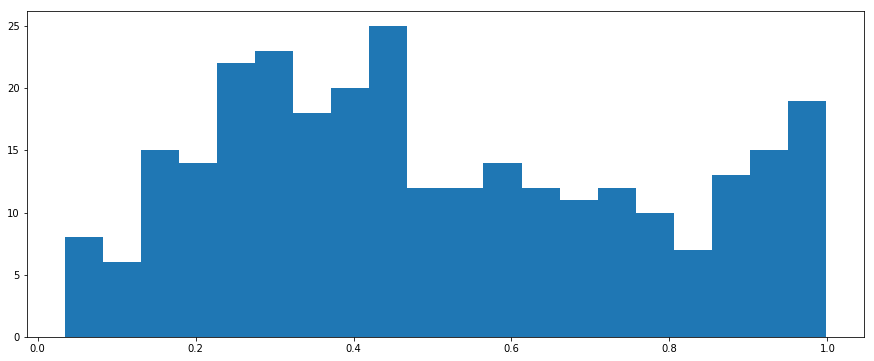

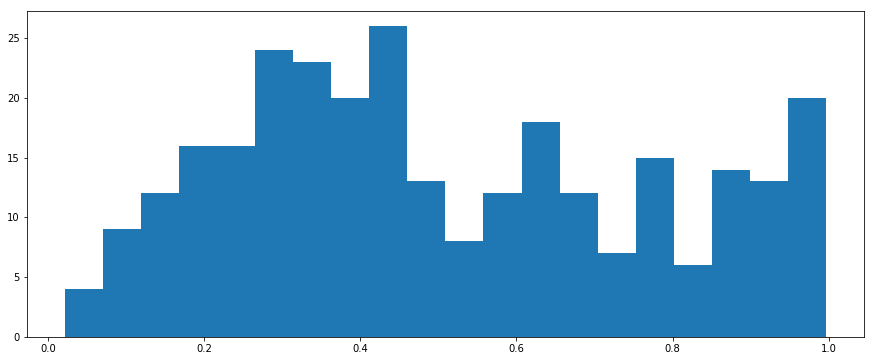

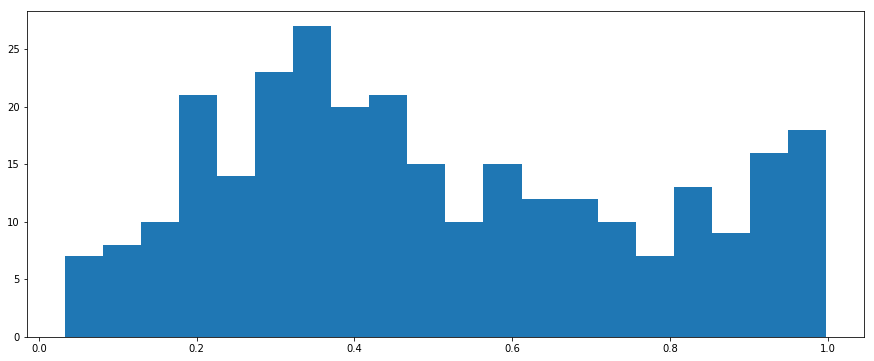

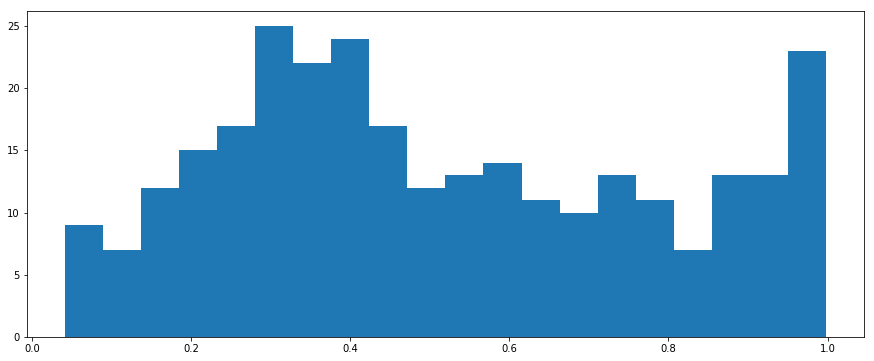

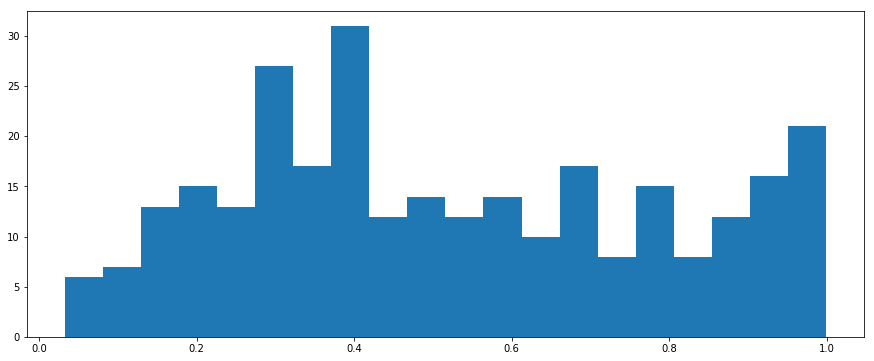

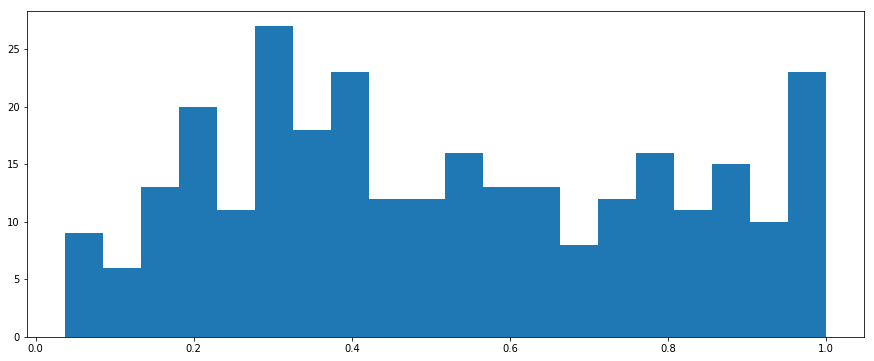

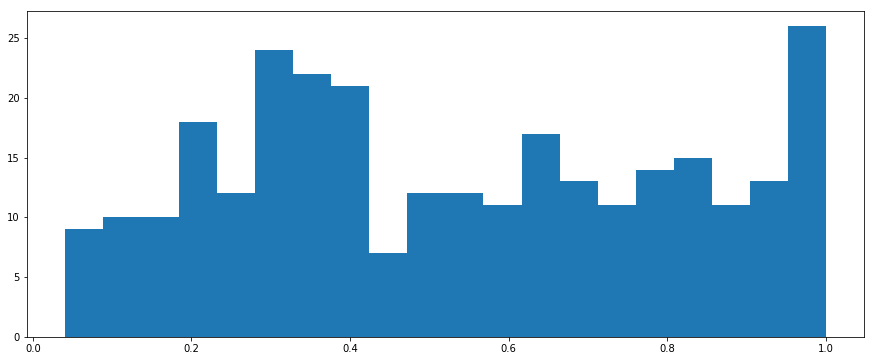

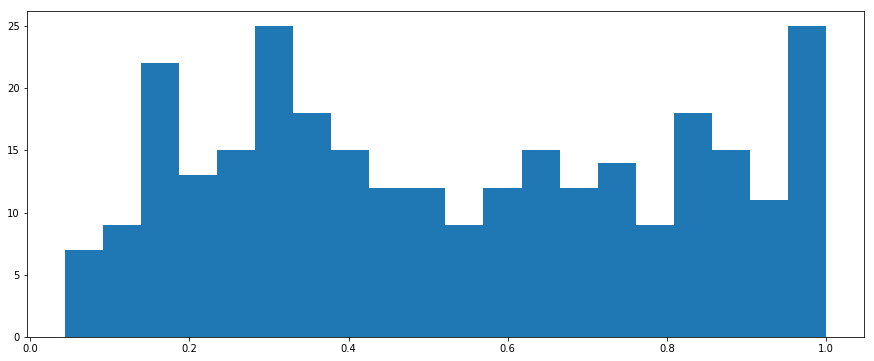

In [17]:
cdf_matrix = predict(model2, total_days=1,day=11,delta=1, show_graph=False)
for i in range (24):
    plt.hist(cdf_matrix[:,i],20)
    plt.show()

## We use Weights to Prioritize Accuracy in the Short Term

Epoch 1/5
11s - loss: 0.0930
Epoch 2/5
11s - loss: 0.0666
Epoch 3/5
10s - loss: 0.0601
Epoch 4/5
10s - loss: 0.0575
Epoch 5/5
10s - loss: 0.0550
Percent Overestimating: 48.4409722222


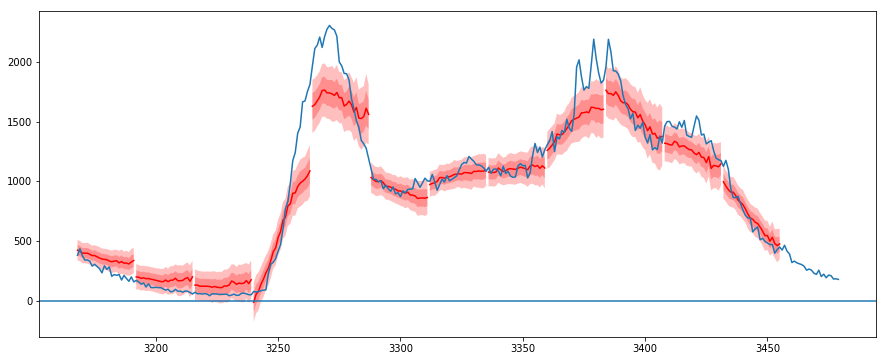

Percent Overestimating: 47.716724537


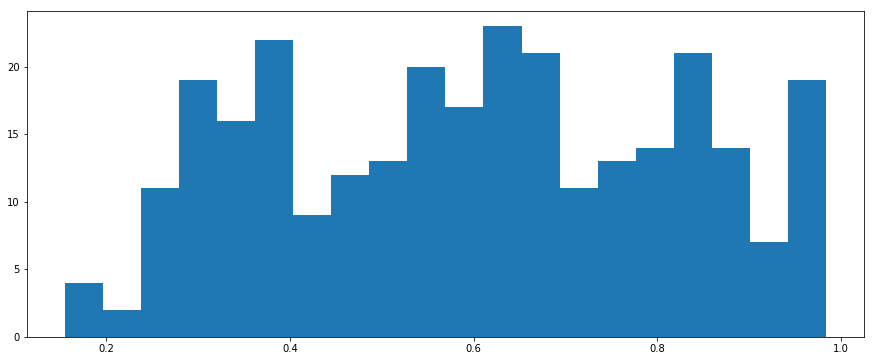

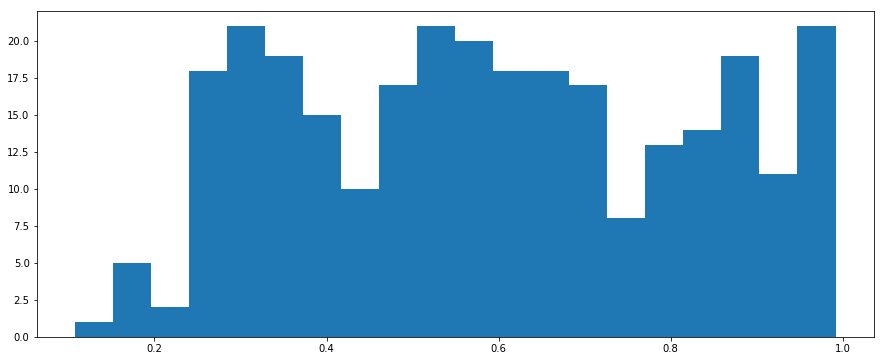

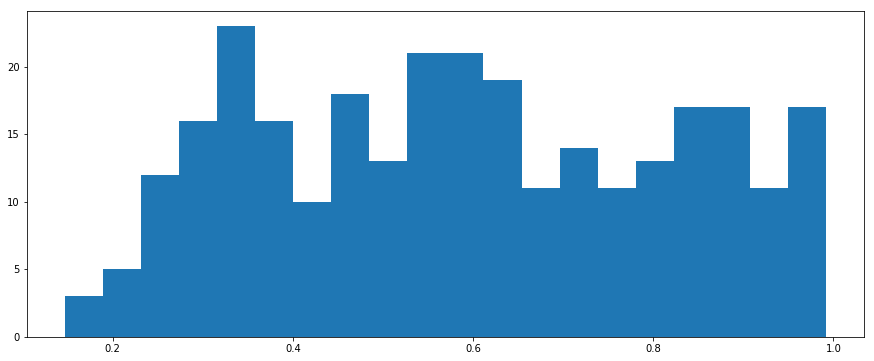

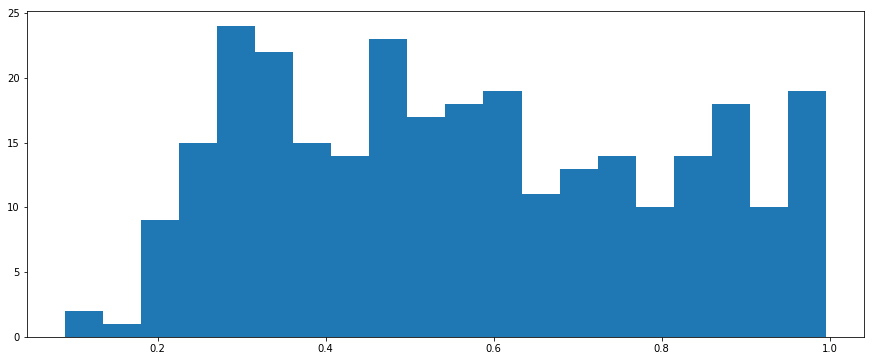

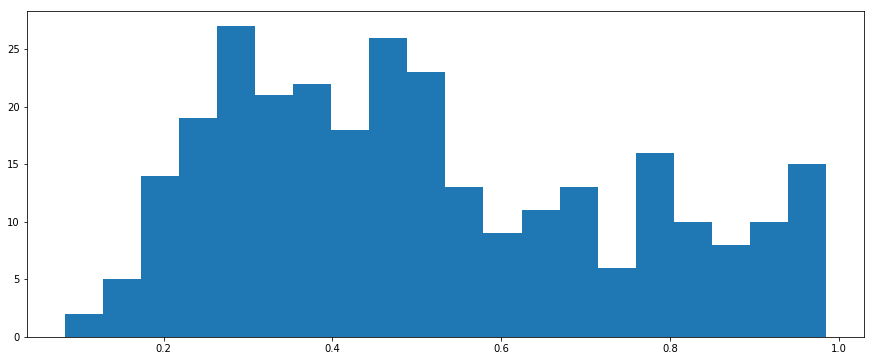

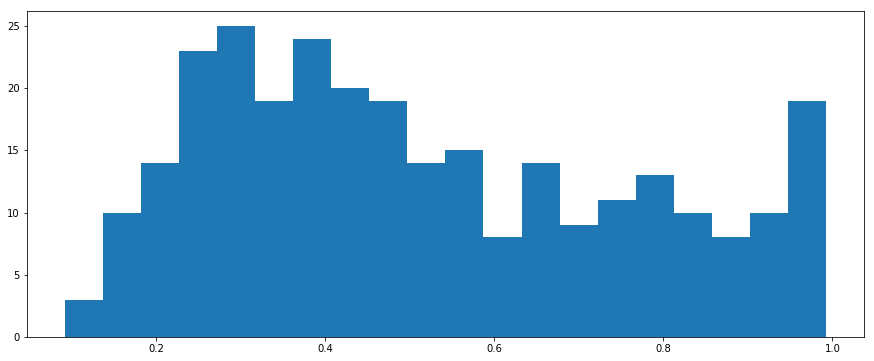

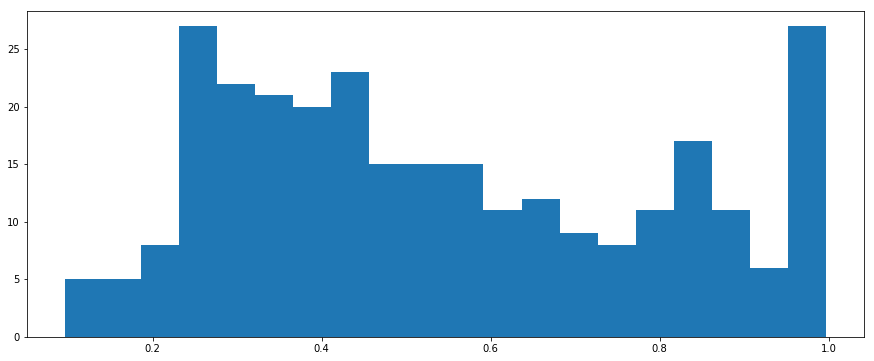

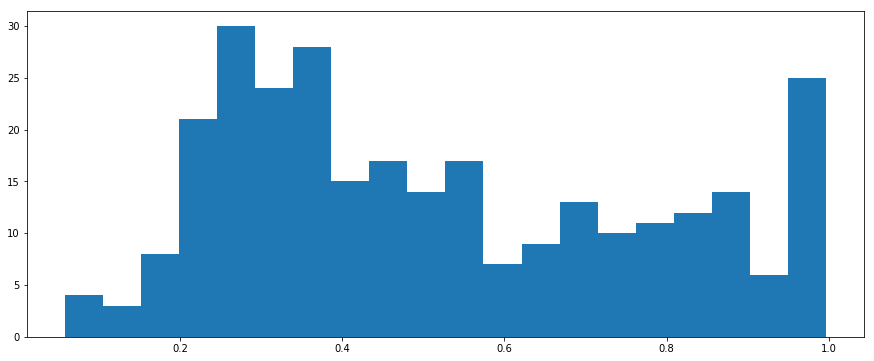

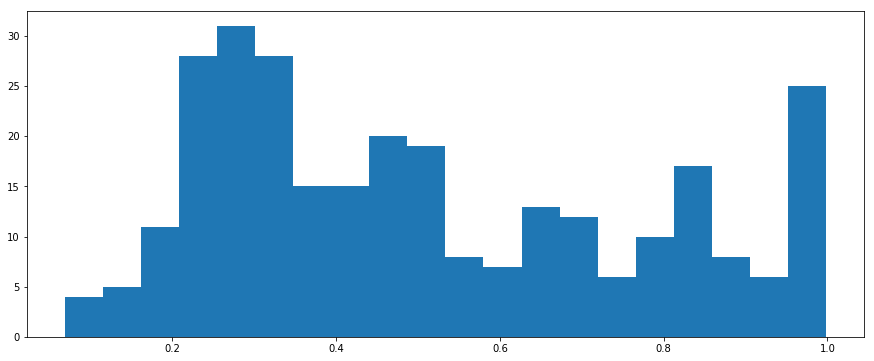

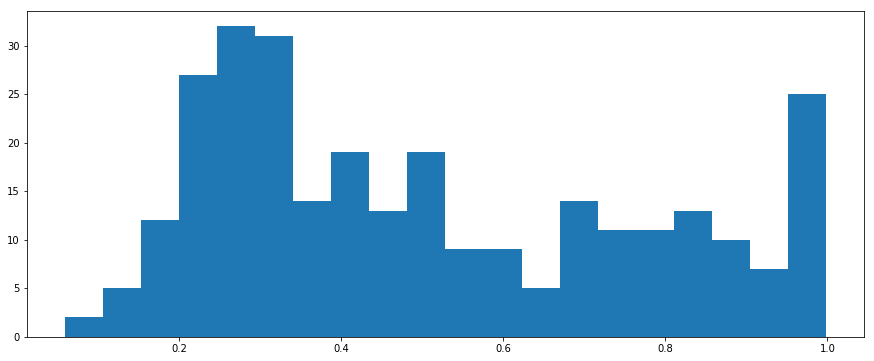

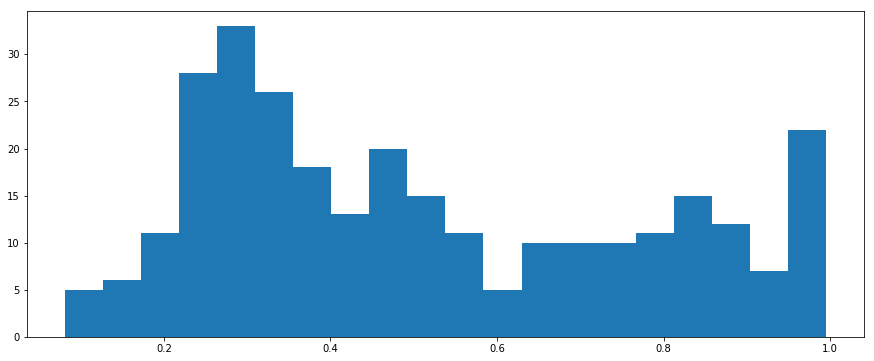

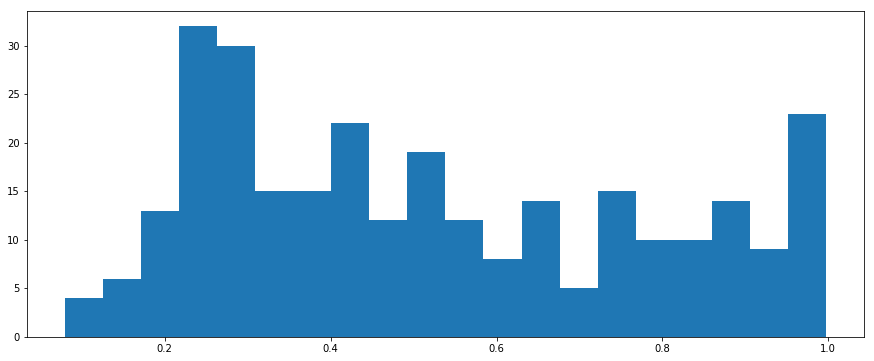

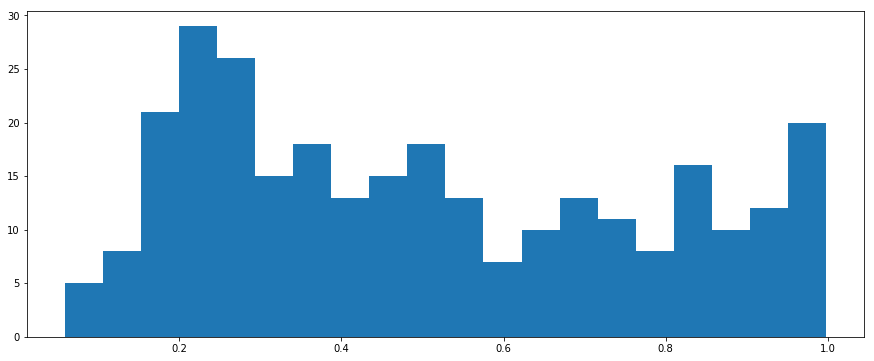

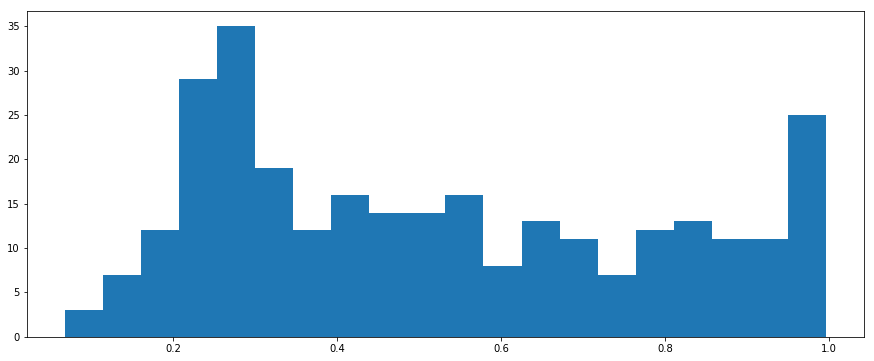

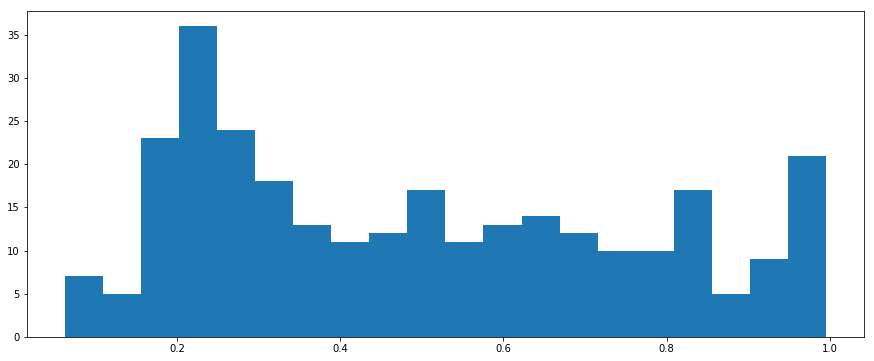

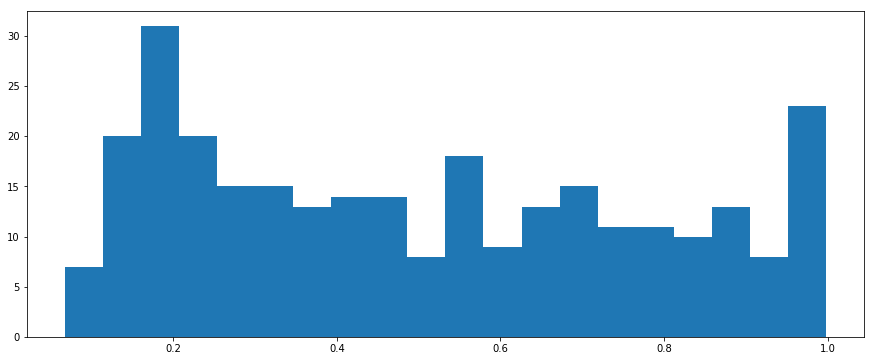

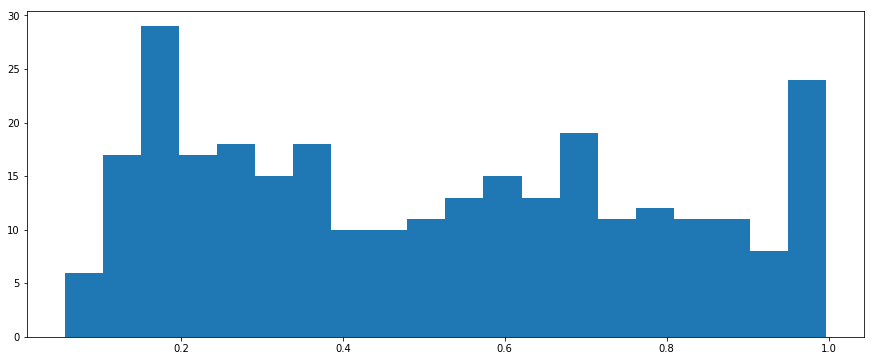

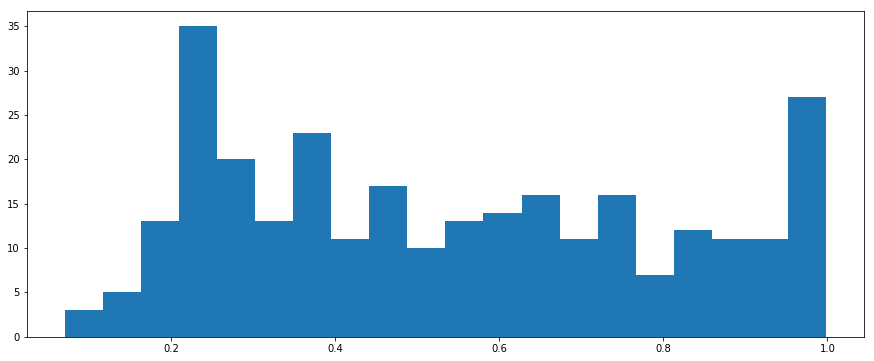

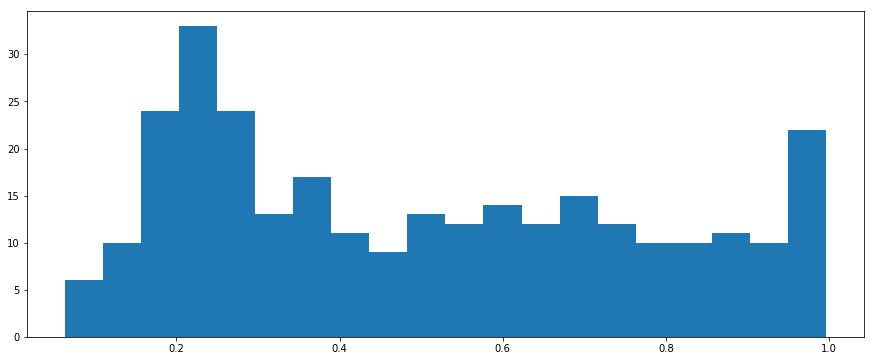

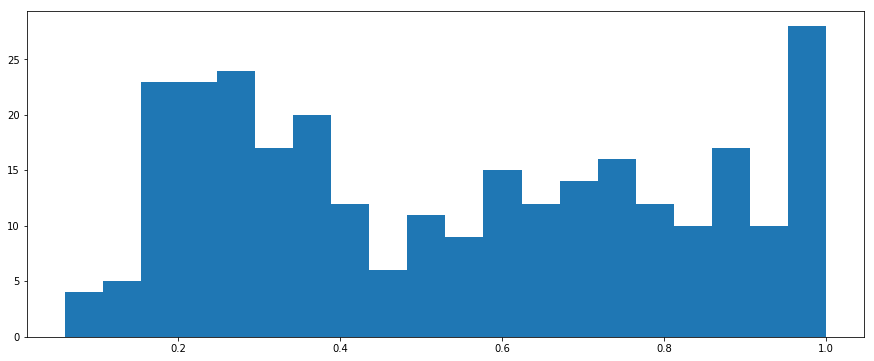

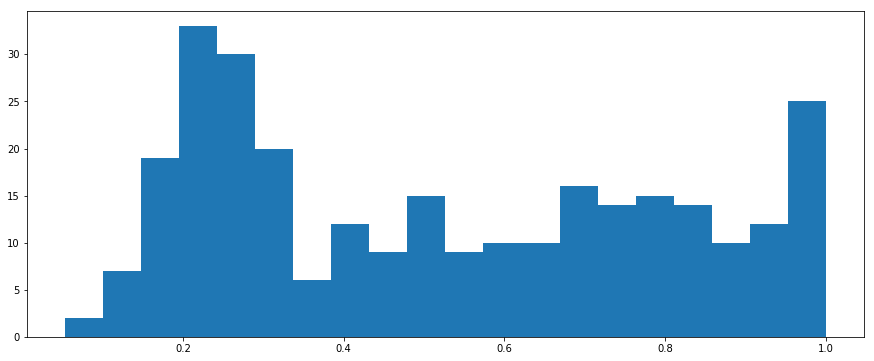

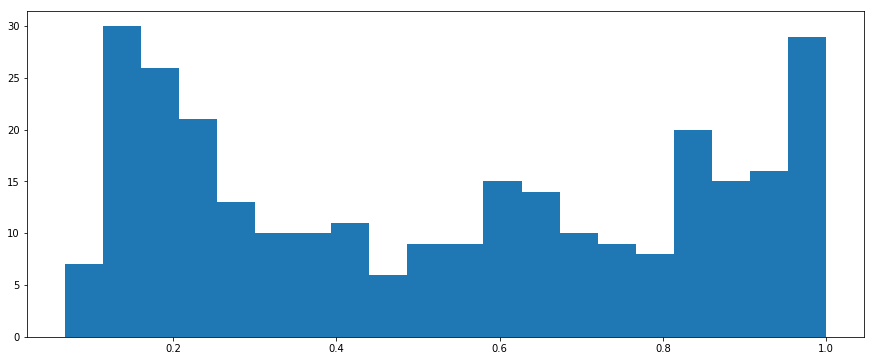

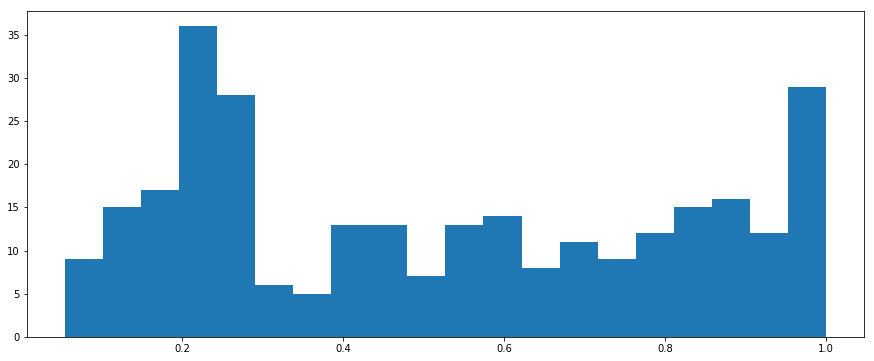

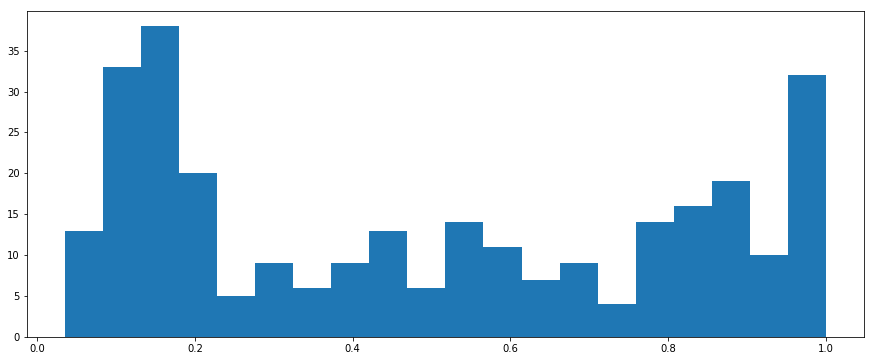

In [18]:

def priorities (y_true, y_pred):
    w = np.arange(1,0, -1./24) ** 2
    w = w / w.sum()
    w = w[:,None]
    W = K.variable(value = w)
    return K.dot( K.abs(y_pred-y_true), W)

batch = 1
seed = 11
# create and fit the LSTM network
model = create_model(rate=0.2)

np.random.seed(seed)
model.compile(loss=priorities, optimizer=RMSprop(lr=0.0002, rho=0.9, epsilon=1e-08, decay=0.0002))
model.fit(trainX, trainY, epochs=5, batch_size=batch, verbose=2)
for i in range (0):
    if i % 10 == 9:
        model.fit(trainX, trainY, epochs=1, batch_size=batch, verbose=2)
    else:
        model.fit(trainX, trainY, epochs=1, batch_size=batch, verbose=3)
predict(model, total_days=1,day=11,delta=24)

cdf_matrix = predict(model, total_days=1,day=11,delta=1, show_graph=False)
for i in range (24):
    plt.hist(cdf_matrix[:,i],20)
    plt.show()

Epoch 1/60
1s - loss: 0.1928
Epoch 2/60
0s - loss: 0.1217
Epoch 3/60
0s - loss: 0.1027
Epoch 4/60
0s - loss: 0.0920
Epoch 5/60
0s - loss: 0.0861
Epoch 6/60
0s - loss: 0.0812
Epoch 7/60
0s - loss: 0.0764
Epoch 8/60
0s - loss: 0.0733
Epoch 9/60
0s - loss: 0.0714
Epoch 10/60
0s - loss: 0.0681
Epoch 11/60
0s - loss: 0.0667
Epoch 12/60
0s - loss: 0.0653
Epoch 13/60
0s - loss: 0.0648
Epoch 14/60
0s - loss: 0.0635
Epoch 15/60
0s - loss: 0.0618
Epoch 16/60
0s - loss: 0.0612
Epoch 17/60
0s - loss: 0.0602
Epoch 18/60
0s - loss: 0.0596
Epoch 19/60
0s - loss: 0.0594
Epoch 20/60
0s - loss: 0.0577
Epoch 21/60
0s - loss: 0.0575
Epoch 22/60
0s - loss: 0.0576
Epoch 23/60
0s - loss: 0.0567
Epoch 24/60
0s - loss: 0.0558
Epoch 25/60
0s - loss: 0.0554
Epoch 26/60
0s - loss: 0.0542
Epoch 27/60
0s - loss: 0.0558
Epoch 28/60
0s - loss: 0.0539
Epoch 29/60
0s - loss: 0.0534
Epoch 30/60
0s - loss: 0.0527
Epoch 31/60
0s - loss: 0.0524
Epoch 32/60
0s - loss: 0.0530
Epoch 33/60
0s - loss: 0.0518
Epoch 34/60
0s - lo

0s - loss: 0.0362
Epoch 2/60
0s - loss: 0.0371
Epoch 3/60
0s - loss: 0.0362
Epoch 4/60
0s - loss: 0.0356
Epoch 5/60
0s - loss: 0.0359
Epoch 6/60
0s - loss: 0.0358
Epoch 7/60
0s - loss: 0.0355
Epoch 8/60
0s - loss: 0.0360
Epoch 9/60
0s - loss: 0.0365
Epoch 10/60
0s - loss: 0.0361
Epoch 11/60
0s - loss: 0.0360
Epoch 12/60
0s - loss: 0.0366
Epoch 13/60
0s - loss: 0.0365
Epoch 14/60
0s - loss: 0.0366
Epoch 15/60
0s - loss: 0.0361
Epoch 16/60
0s - loss: 0.0367
Epoch 17/60
0s - loss: 0.0366
Epoch 18/60
0s - loss: 0.0360
Epoch 19/60
0s - loss: 0.0359
Epoch 20/60
0s - loss: 0.0367
Epoch 21/60
0s - loss: 0.0360
Epoch 22/60
0s - loss: 0.0363
Epoch 23/60
0s - loss: 0.0359
Epoch 24/60
0s - loss: 0.0357
Epoch 25/60
0s - loss: 0.0362
Epoch 26/60
0s - loss: 0.0364
Epoch 27/60
0s - loss: 0.0359
Epoch 28/60
0s - loss: 0.0361
Epoch 29/60
0s - loss: 0.0361
Epoch 30/60
0s - loss: 0.0361
Epoch 31/60
0s - loss: 0.0362
Epoch 32/60
0s - loss: 0.0357
Epoch 33/60
0s - loss: 0.0367
Epoch 34/60
0s - loss: 0.0358


0s - loss: 0.0340
Epoch 3/60
0s - loss: 0.0340
Epoch 4/60
0s - loss: 0.0336
Epoch 5/60
0s - loss: 0.0344
Epoch 6/60
0s - loss: 0.0338
Epoch 7/60
0s - loss: 0.0332
Epoch 8/60
0s - loss: 0.0337
Epoch 9/60
0s - loss: 0.0341
Epoch 10/60
0s - loss: 0.0338
Epoch 11/60
0s - loss: 0.0336
Epoch 12/60
0s - loss: 0.0338
Epoch 13/60
0s - loss: 0.0340
Epoch 14/60
0s - loss: 0.0340
Epoch 15/60
0s - loss: 0.0350
Epoch 16/60
0s - loss: 0.0334
Epoch 17/60
0s - loss: 0.0346
Epoch 18/60
0s - loss: 0.0338
Epoch 19/60
0s - loss: 0.0339
Epoch 20/60
0s - loss: 0.0336
Epoch 21/60
0s - loss: 0.0344
Epoch 22/60
0s - loss: 0.0344
Epoch 23/60
0s - loss: 0.0337
Epoch 24/60
0s - loss: 0.0336
Epoch 25/60
0s - loss: 0.0333
Epoch 26/60
0s - loss: 0.0337
Epoch 27/60
0s - loss: 0.0335
Epoch 28/60
0s - loss: 0.0340
Epoch 29/60
0s - loss: 0.0338
Epoch 30/60
0s - loss: 0.0341
Epoch 31/60
0s - loss: 0.0333
Epoch 32/60
0s - loss: 0.0336
Epoch 33/60
0s - loss: 0.0344
Epoch 34/60
0s - loss: 0.0333
Epoch 35/60
0s - loss: 0.0345

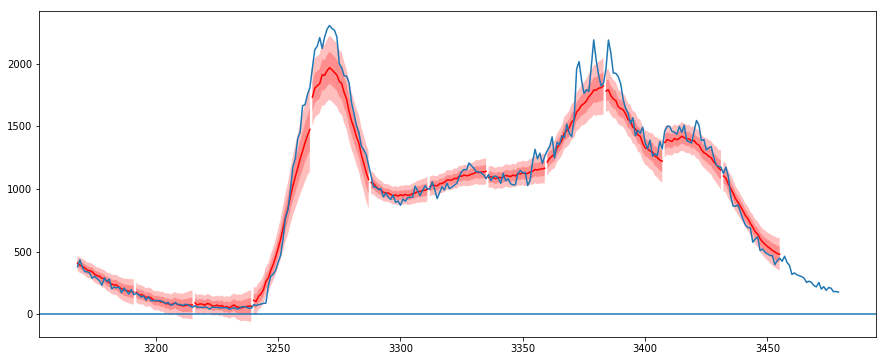

Percent Overestimating: 47.0520833333


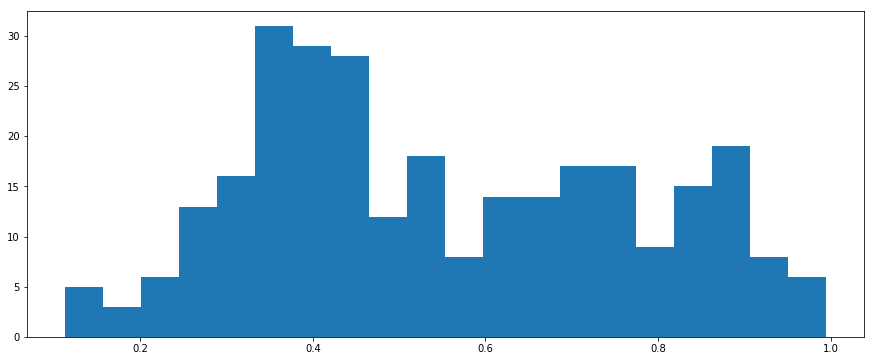

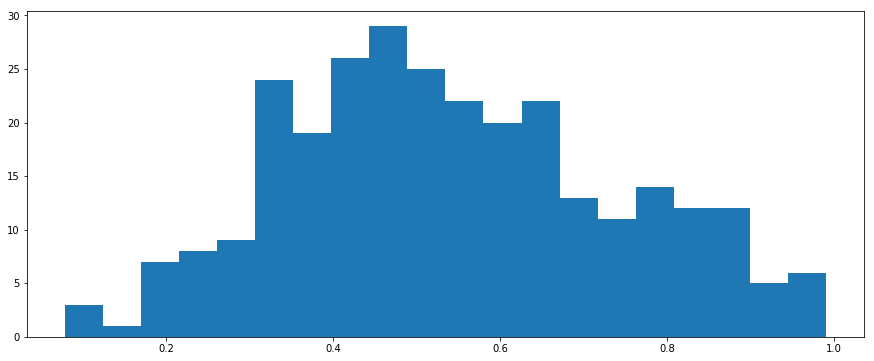

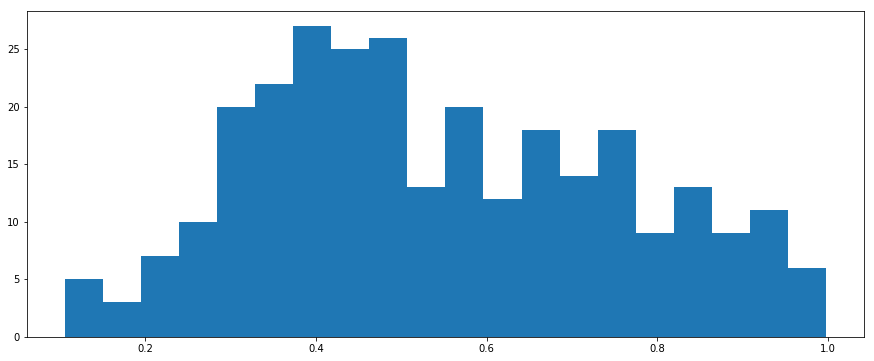

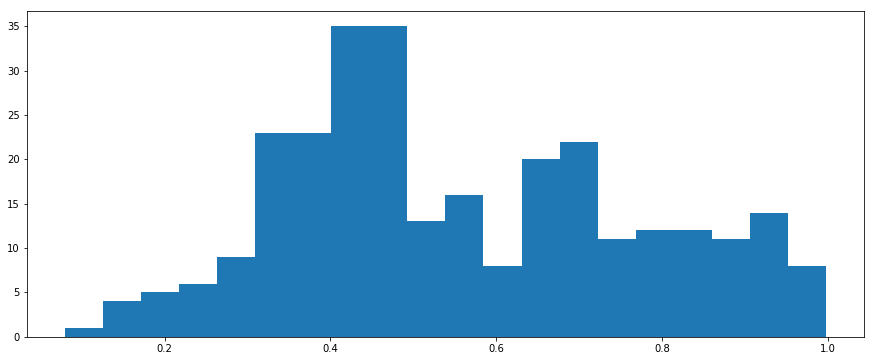

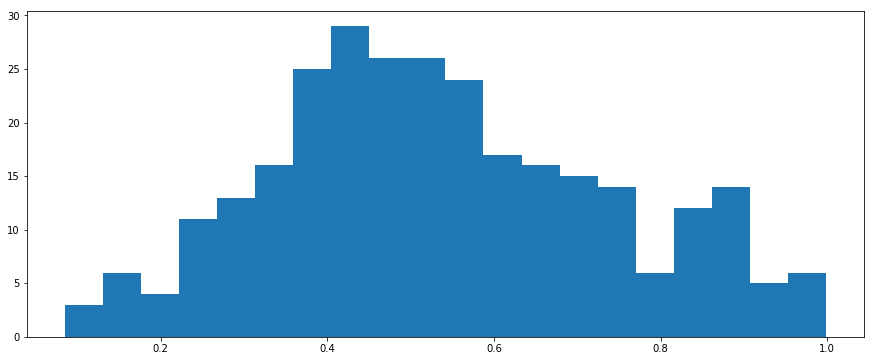

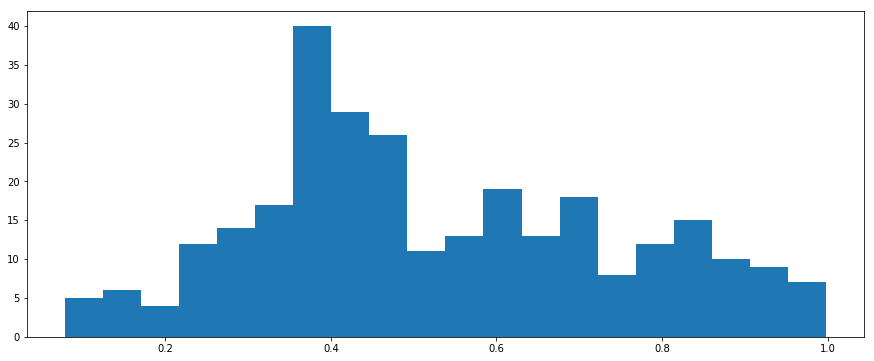

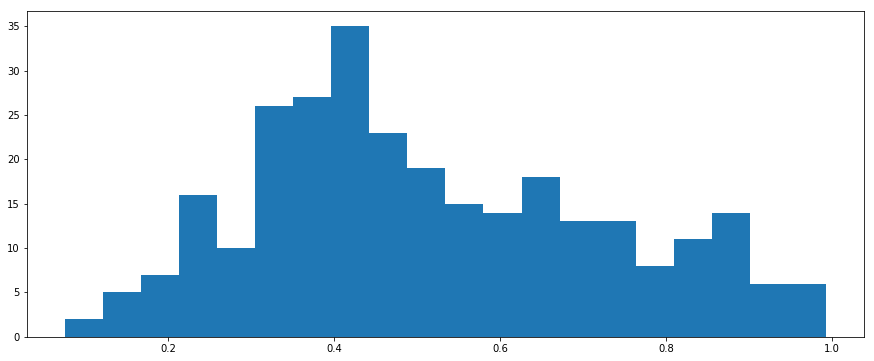

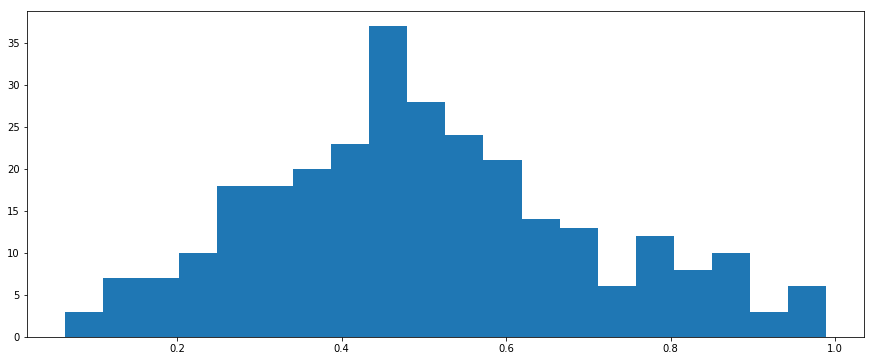

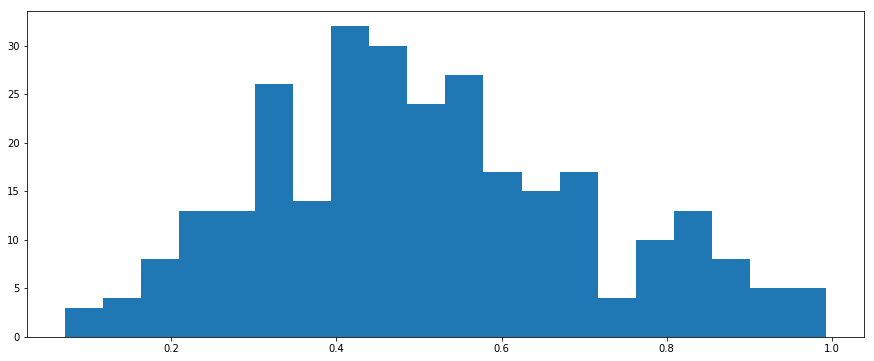

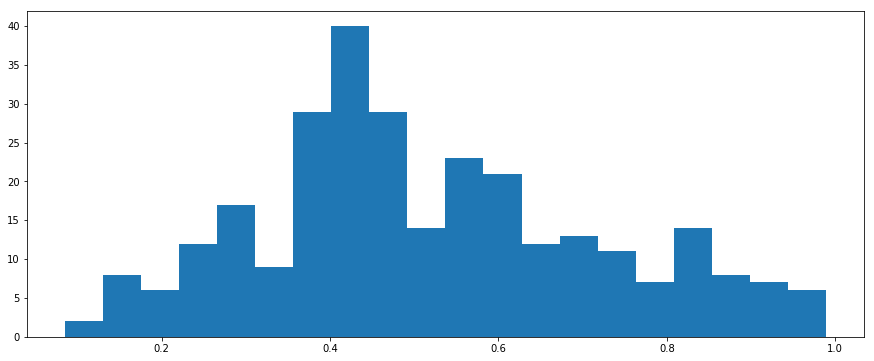

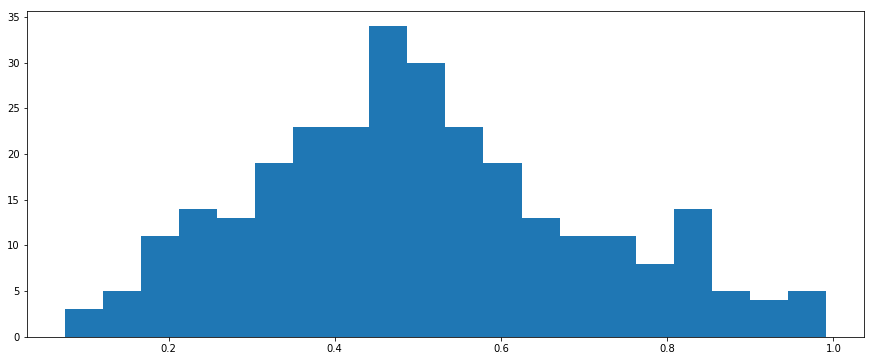

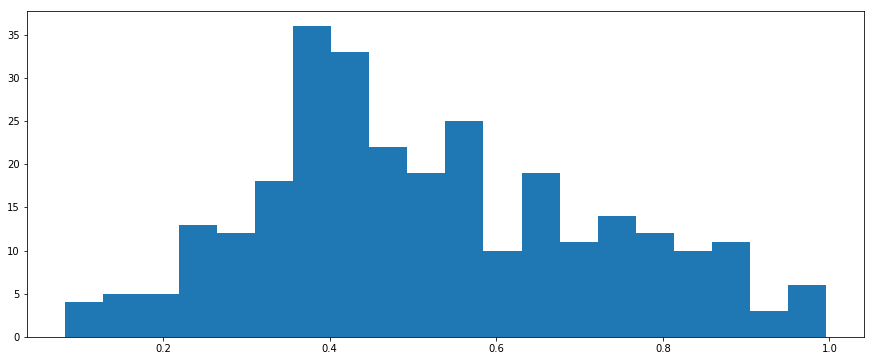

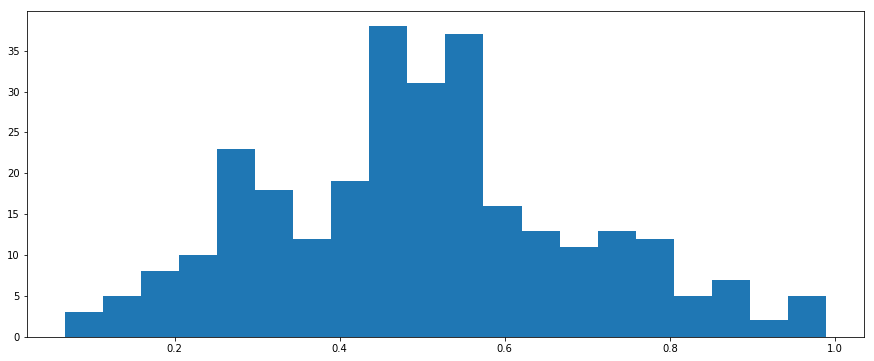

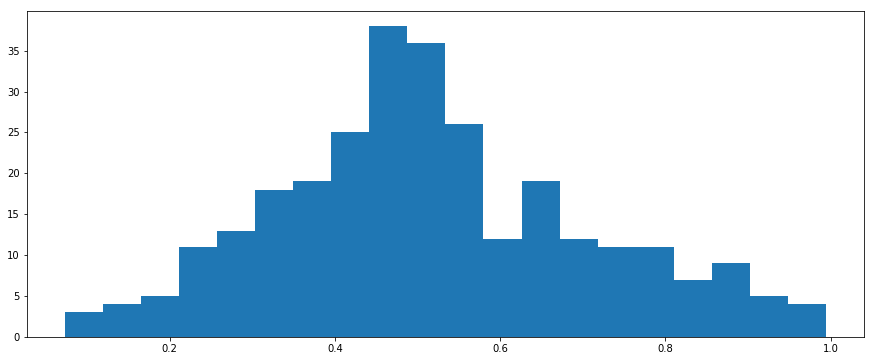

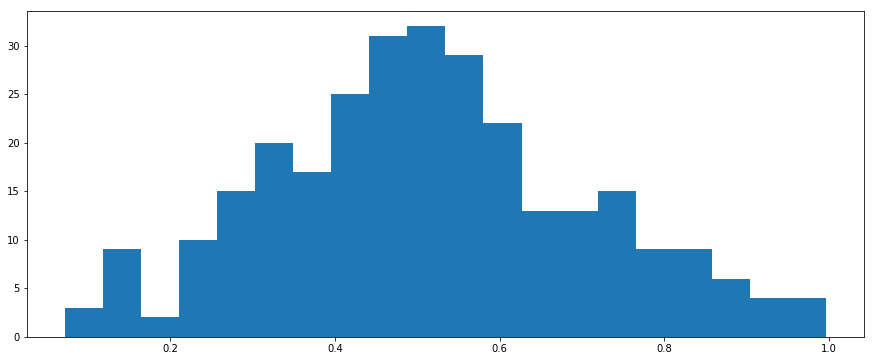

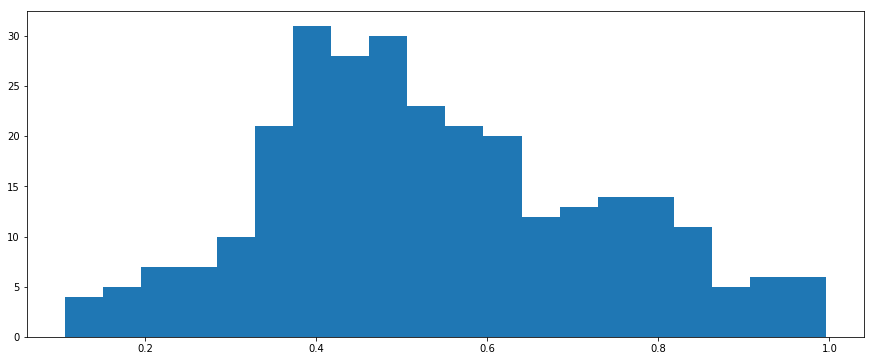

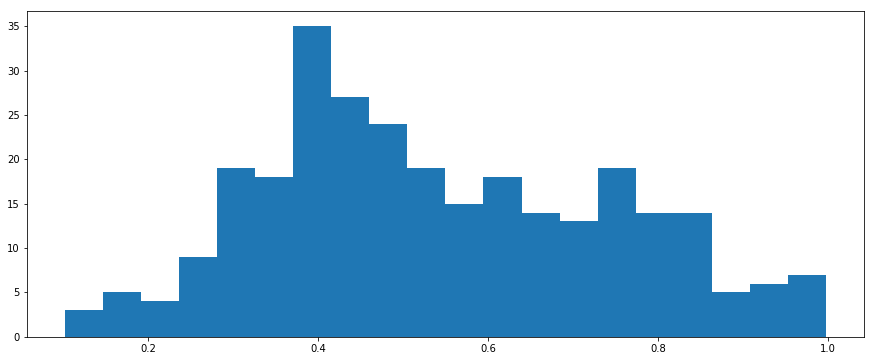

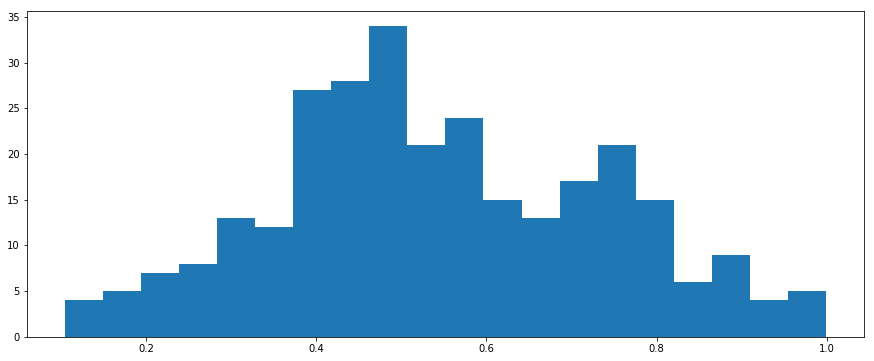

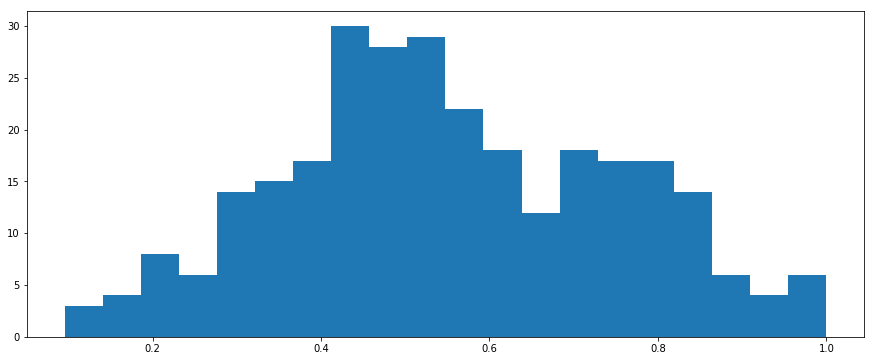

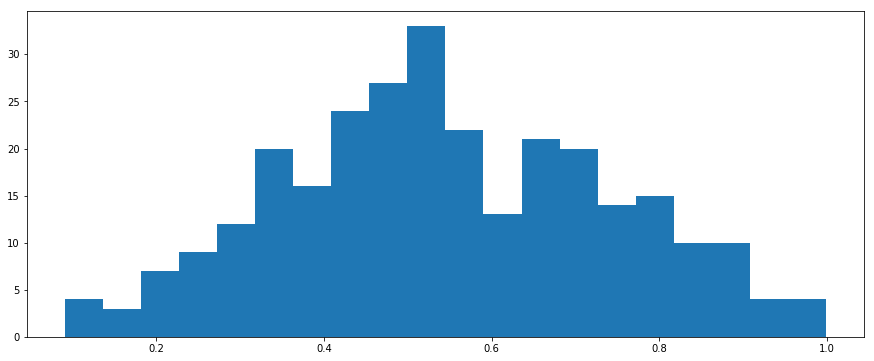

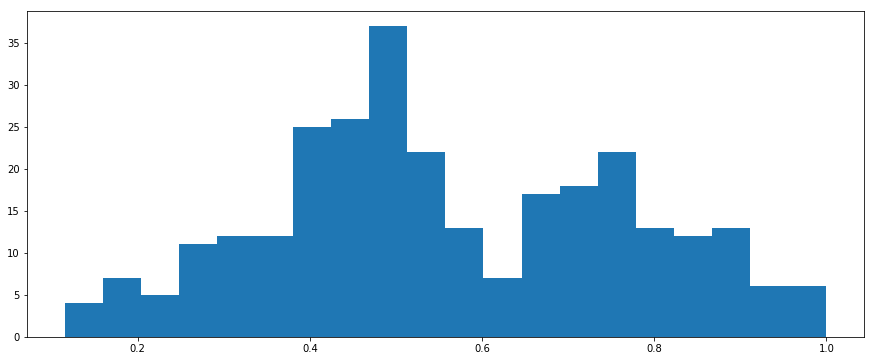

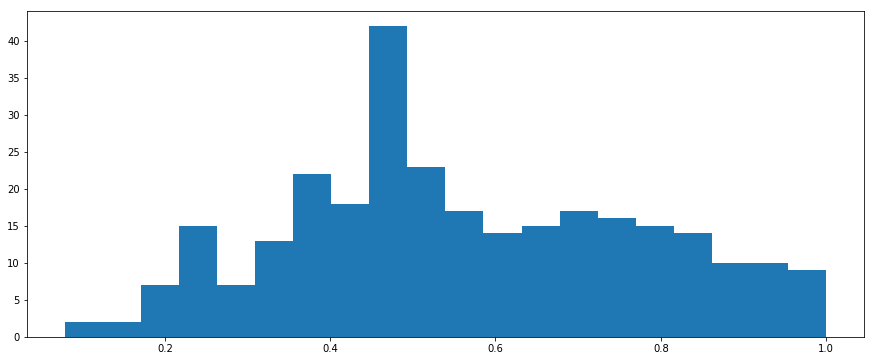

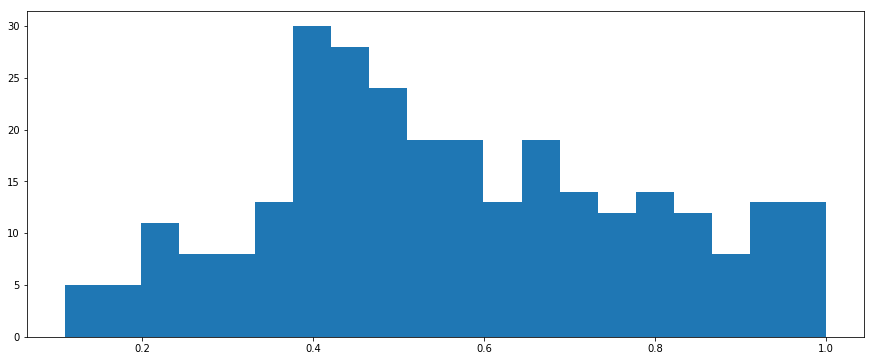

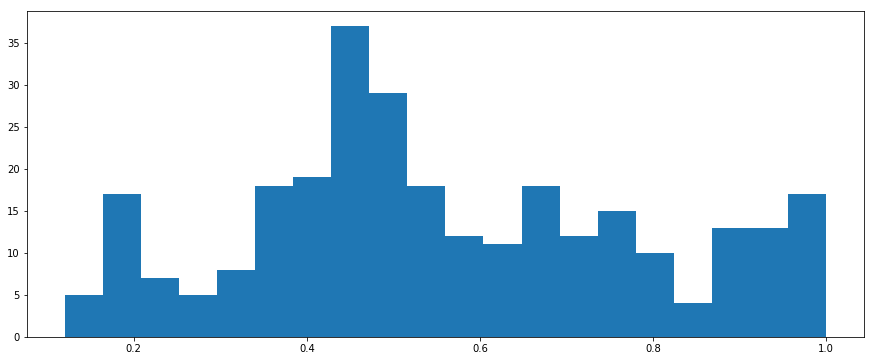

In [36]:
## Results from Hyper Parameter Search...
# Best Epoch - 60
# Best Batch - 60
# Best Decay - 0.0
# Best Learning Rate - 0.0001


def priorities (y_true, y_pred):
    w = np.arange(1,0, -1./24) ** 2
    w = w / w.sum()
    w = w[:,None]
    W = K.variable(value = w)
    return K.dot( K.abs(y_pred-y_true), W)

batch = 60
seed = 11
# create and fit the LSTM network
model = create_model(rate=0.2)
np.random.seed(seed)
model.compile(loss=priorities, optimizer=RMSprop(lr=0.0001, rho=0.9, epsilon=1e-08, decay=0.0))
model.fit(trainX, trainY, epochs=60, batch_size=60, verbose=2)
for i in range (20):
    if i % 10 == 9:
        model.fit(trainX, trainY, epochs=60, batch_size=60, verbose=2)
    else:
        model.fit(trainX, trainY, epochs=60, batch_size=60, verbose=3)
predict(model, total_days=1,day=11,delta=24)

cdf_matrix = predict(model, total_days=1,day=11,delta=1, show_graph=False)
for i in range (24):
    plt.hist(cdf_matrix[:,i],20)
    plt.show()

Epoch 1/60
1s - loss: 0.1638
Epoch 2/60
0s - loss: 0.1043
Epoch 3/60
0s - loss: 0.0890
Epoch 4/60
0s - loss: 0.0805
Epoch 5/60
0s - loss: 0.0758
Epoch 6/60
0s - loss: 0.0711
Epoch 7/60
0s - loss: 0.0687
Epoch 8/60
0s - loss: 0.0650
Epoch 9/60
0s - loss: 0.0665
Epoch 10/60
0s - loss: 0.0630
Epoch 11/60
0s - loss: 0.0627
Epoch 12/60
0s - loss: 0.0604
Epoch 13/60
0s - loss: 0.0588
Epoch 14/60
0s - loss: 0.0585
Epoch 15/60
0s - loss: 0.0572
Epoch 16/60
0s - loss: 0.0570
Epoch 17/60
0s - loss: 0.0557
Epoch 18/60
0s - loss: 0.0558
Epoch 19/60
0s - loss: 0.0548
Epoch 20/60
0s - loss: 0.0535
Epoch 21/60
0s - loss: 0.0527
Epoch 22/60
0s - loss: 0.0531
Epoch 23/60
0s - loss: 0.0523
Epoch 24/60
0s - loss: 0.0525
Epoch 25/60
0s - loss: 0.0526
Epoch 26/60
0s - loss: 0.0506
Epoch 27/60
0s - loss: 0.0495
Epoch 28/60
0s - loss: 0.0509
Epoch 29/60
0s - loss: 0.0503
Epoch 30/60
0s - loss: 0.0488
Epoch 31/60
0s - loss: 0.0490
Epoch 32/60
0s - loss: 0.0493
Epoch 33/60
0s - loss: 0.0494
Epoch 34/60
0s - lo

0s - loss: 0.0368
Epoch 2/60
0s - loss: 0.0361
Epoch 3/60
0s - loss: 0.0366
Epoch 4/60
0s - loss: 0.0363
Epoch 5/60
0s - loss: 0.0366
Epoch 6/60
0s - loss: 0.0369
Epoch 7/60
0s - loss: 0.0364
Epoch 8/60
0s - loss: 0.0371
Epoch 9/60
0s - loss: 0.0355
Epoch 10/60
0s - loss: 0.0369
Epoch 11/60
0s - loss: 0.0364
Epoch 12/60
0s - loss: 0.0360
Epoch 13/60
0s - loss: 0.0363
Epoch 14/60
0s - loss: 0.0366
Epoch 15/60
0s - loss: 0.0368
Epoch 16/60
0s - loss: 0.0367
Epoch 17/60
0s - loss: 0.0363
Epoch 18/60
0s - loss: 0.0365
Epoch 19/60
0s - loss: 0.0363
Epoch 20/60
0s - loss: 0.0363
Epoch 21/60
0s - loss: 0.0365
Epoch 22/60
0s - loss: 0.0364
Epoch 23/60
0s - loss: 0.0361
Epoch 24/60
0s - loss: 0.0368
Epoch 25/60
0s - loss: 0.0365
Epoch 26/60
0s - loss: 0.0367
Epoch 27/60
0s - loss: 0.0366
Epoch 28/60
0s - loss: 0.0365
Epoch 29/60
0s - loss: 0.0363
Epoch 30/60
0s - loss: 0.0363
Epoch 31/60
0s - loss: 0.0364
Epoch 32/60
0s - loss: 0.0368
Epoch 33/60
0s - loss: 0.0360
Epoch 34/60
0s - loss: 0.0365


0s - loss: 0.0349
Epoch 3/60
0s - loss: 0.0346
Epoch 4/60
0s - loss: 0.0350
Epoch 5/60
0s - loss: 0.0353
Epoch 6/60
0s - loss: 0.0351
Epoch 7/60
0s - loss: 0.0349
Epoch 8/60
0s - loss: 0.0349
Epoch 9/60
0s - loss: 0.0346
Epoch 10/60
0s - loss: 0.0354
Epoch 11/60
0s - loss: 0.0348
Epoch 12/60
0s - loss: 0.0348
Epoch 13/60
0s - loss: 0.0352
Epoch 14/60
0s - loss: 0.0355
Epoch 15/60
0s - loss: 0.0352
Epoch 16/60
0s - loss: 0.0350
Epoch 17/60
0s - loss: 0.0351
Epoch 18/60
0s - loss: 0.0351
Epoch 19/60
0s - loss: 0.0347
Epoch 20/60
0s - loss: 0.0353
Epoch 21/60
0s - loss: 0.0347
Epoch 22/60
0s - loss: 0.0352
Epoch 23/60
0s - loss: 0.0350
Epoch 24/60
0s - loss: 0.0350
Epoch 25/60
0s - loss: 0.0345
Epoch 26/60
0s - loss: 0.0358
Epoch 27/60
0s - loss: 0.0353
Epoch 28/60
0s - loss: 0.0359
Epoch 29/60
0s - loss: 0.0352
Epoch 30/60
0s - loss: 0.0350
Epoch 31/60
0s - loss: 0.0352
Epoch 32/60
0s - loss: 0.0351
Epoch 33/60
0s - loss: 0.0344
Epoch 34/60
0s - loss: 0.0349
Epoch 35/60
0s - loss: 0.0355

0s - loss: 0.0342
Epoch 4/60
0s - loss: 0.0347
Epoch 5/60
0s - loss: 0.0344
Epoch 6/60
0s - loss: 0.0340
Epoch 7/60
0s - loss: 0.0346
Epoch 8/60
0s - loss: 0.0344
Epoch 9/60
0s - loss: 0.0342
Epoch 10/60
0s - loss: 0.0342
Epoch 11/60
0s - loss: 0.0345
Epoch 12/60
0s - loss: 0.0347
Epoch 13/60
0s - loss: 0.0344
Epoch 14/60
0s - loss: 0.0346
Epoch 15/60
0s - loss: 0.0342
Epoch 16/60
0s - loss: 0.0342
Epoch 17/60
0s - loss: 0.0345
Epoch 18/60
0s - loss: 0.0349
Epoch 19/60
0s - loss: 0.0347
Epoch 20/60
0s - loss: 0.0350
Epoch 21/60
0s - loss: 0.0346
Epoch 22/60
0s - loss: 0.0349
Epoch 23/60
0s - loss: 0.0353
Epoch 24/60
0s - loss: 0.0349
Epoch 25/60
0s - loss: 0.0345
Epoch 26/60
0s - loss: 0.0347
Epoch 27/60
0s - loss: 0.0343
Epoch 28/60
0s - loss: 0.0346
Epoch 29/60
0s - loss: 0.0344
Epoch 30/60
0s - loss: 0.0345
Epoch 31/60
0s - loss: 0.0347
Epoch 32/60
0s - loss: 0.0341
Epoch 33/60
0s - loss: 0.0348
Epoch 34/60
0s - loss: 0.0350
Epoch 35/60
0s - loss: 0.0345
Epoch 36/60
0s - loss: 0.033

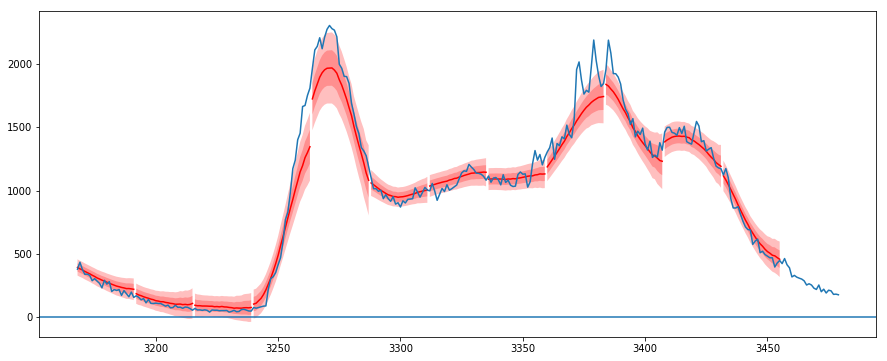

Percent Overestimating: 49.5623553241


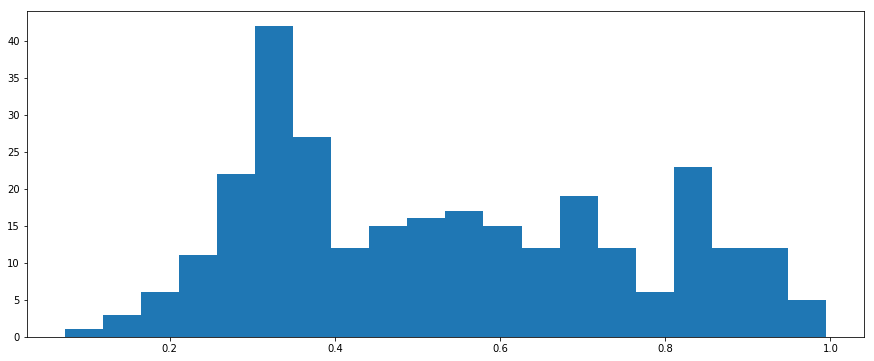

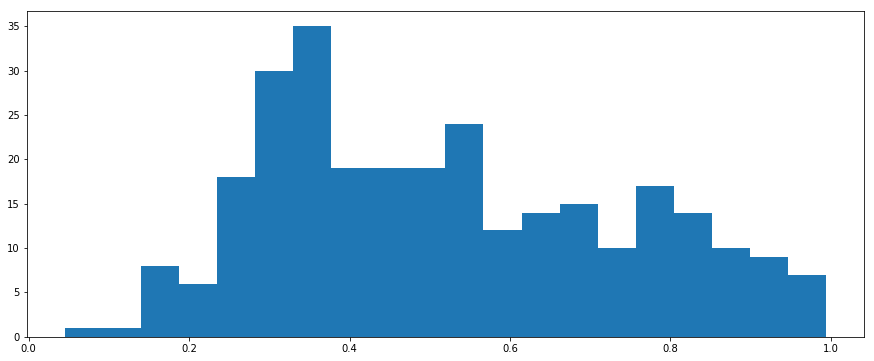

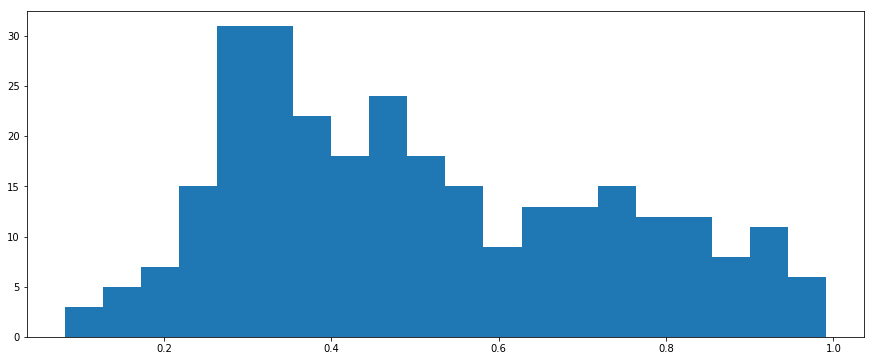

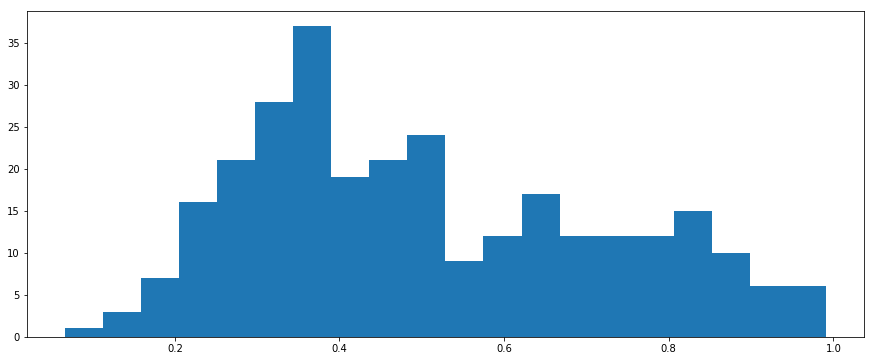

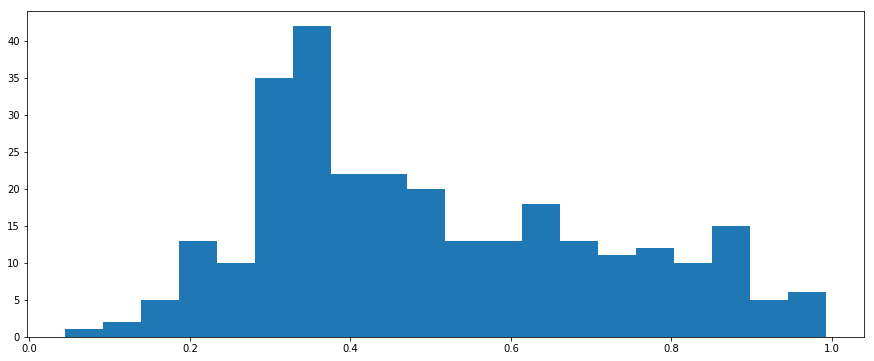

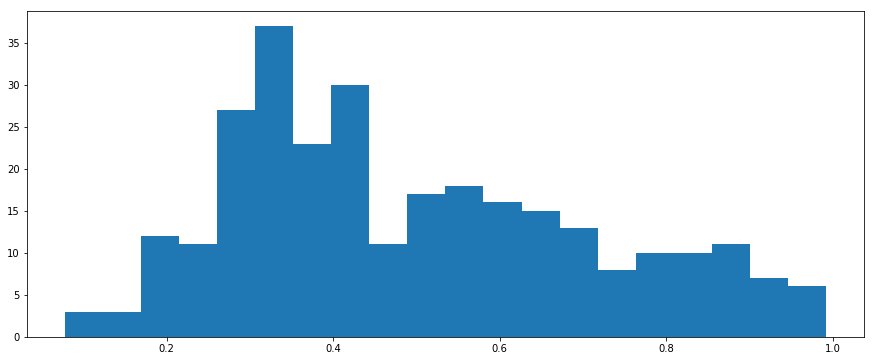

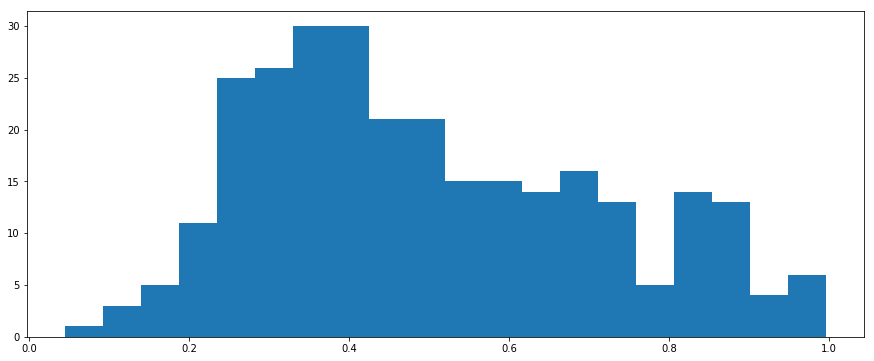

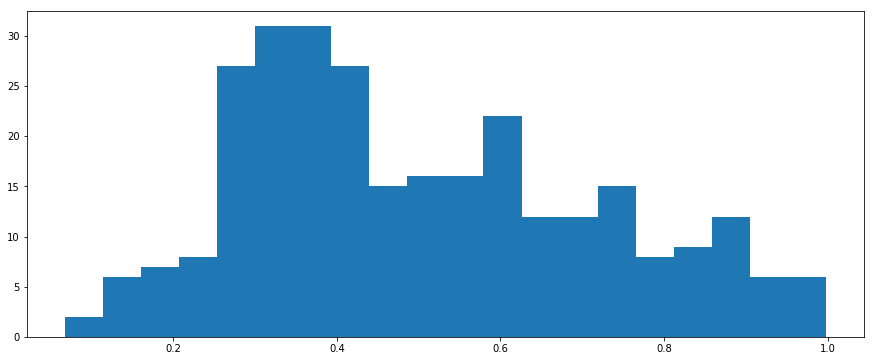

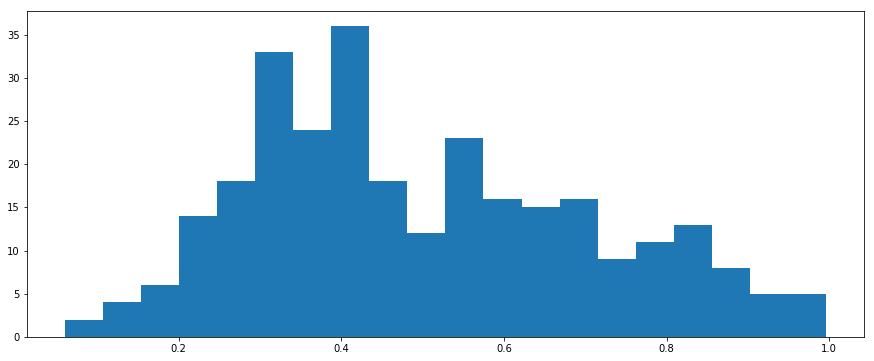

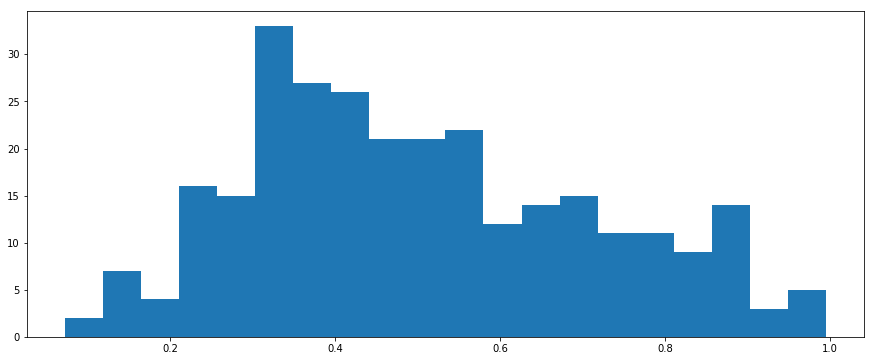

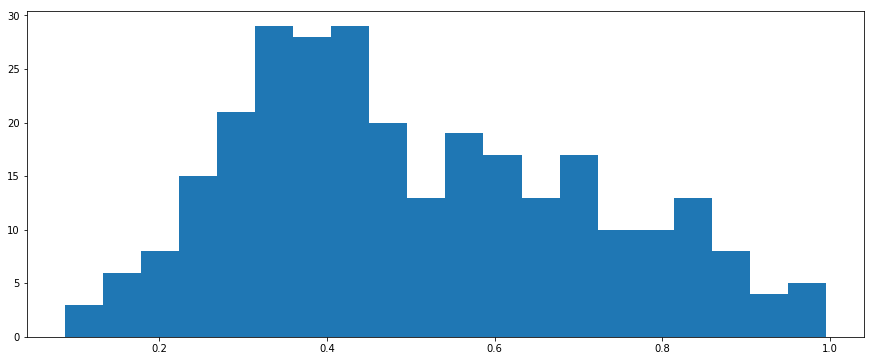

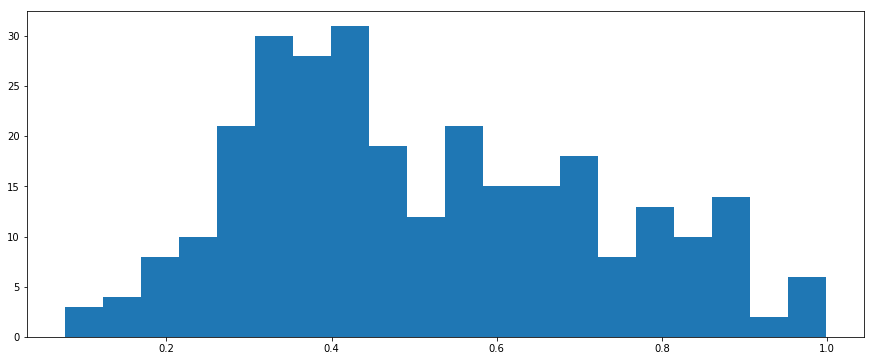

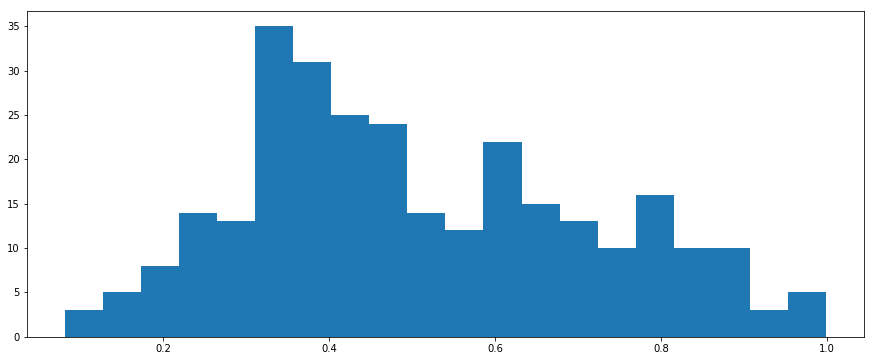

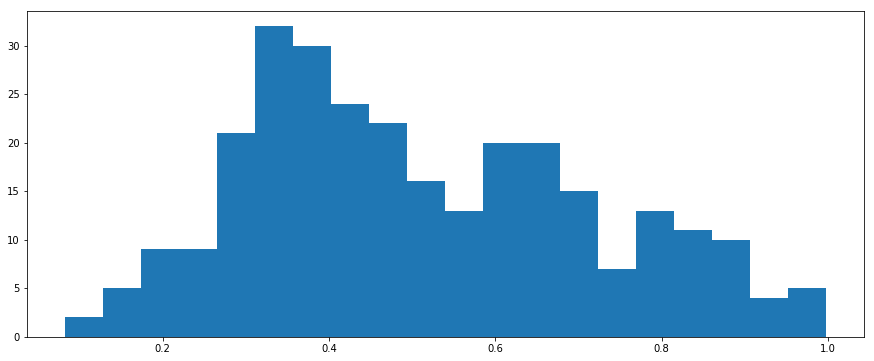

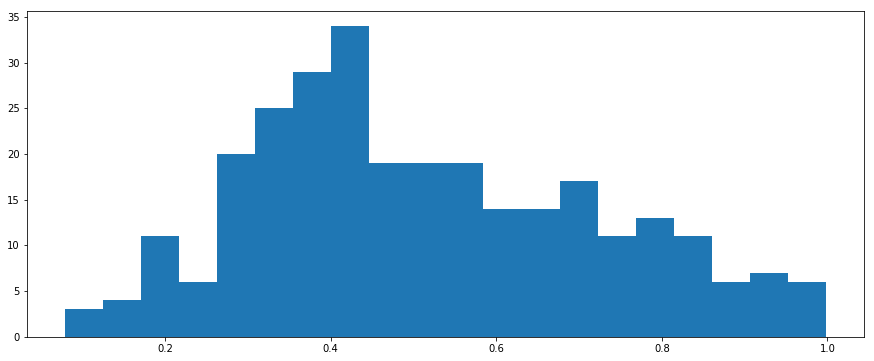

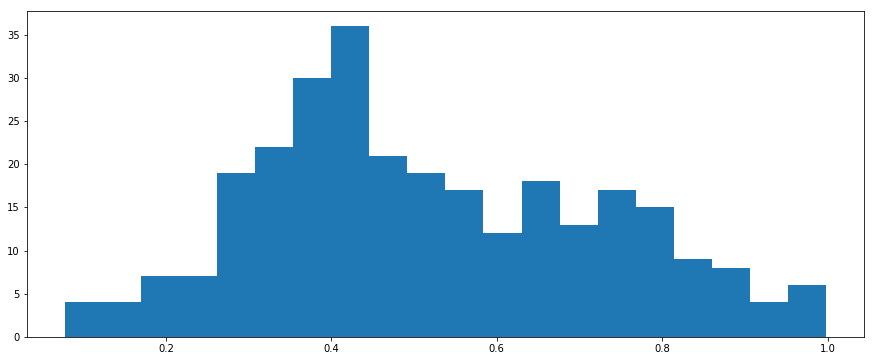

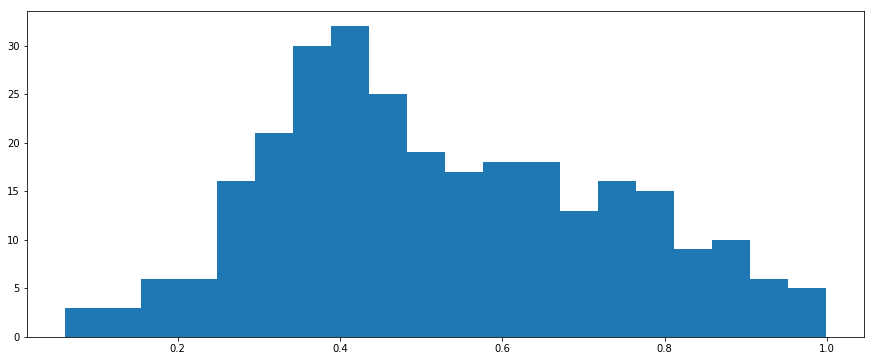

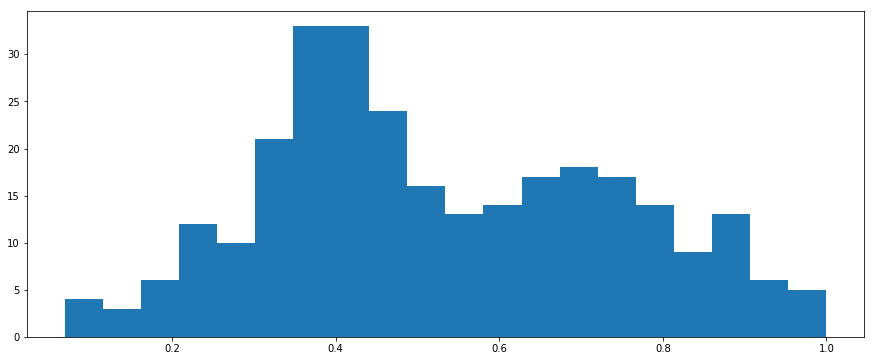

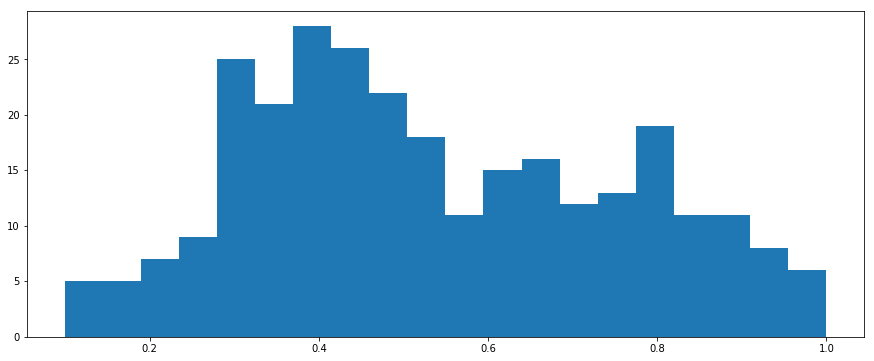

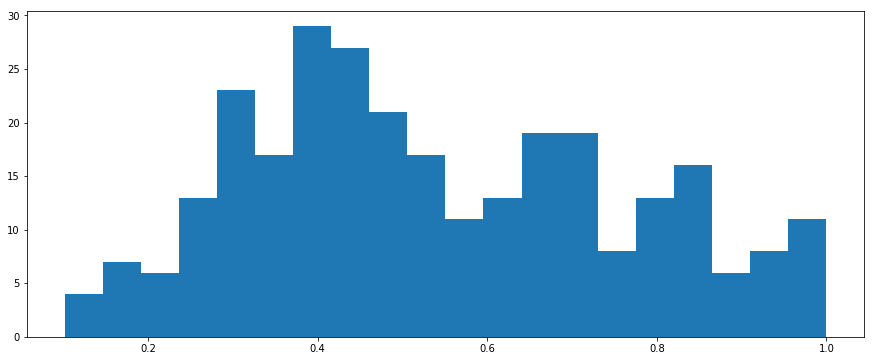

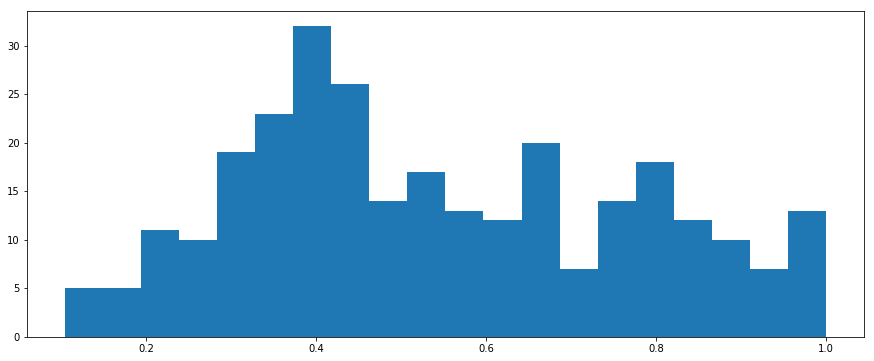

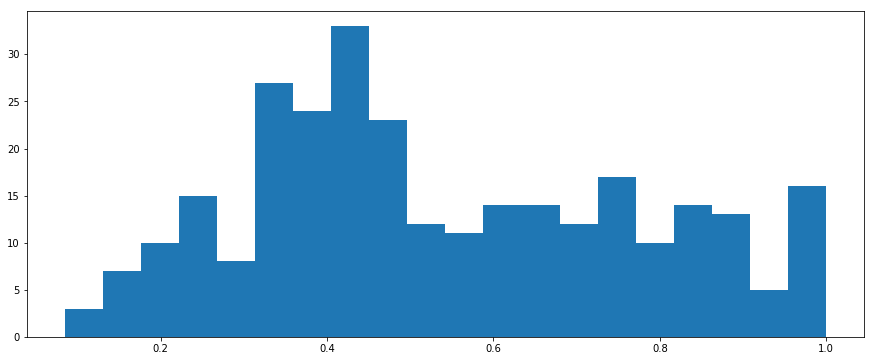

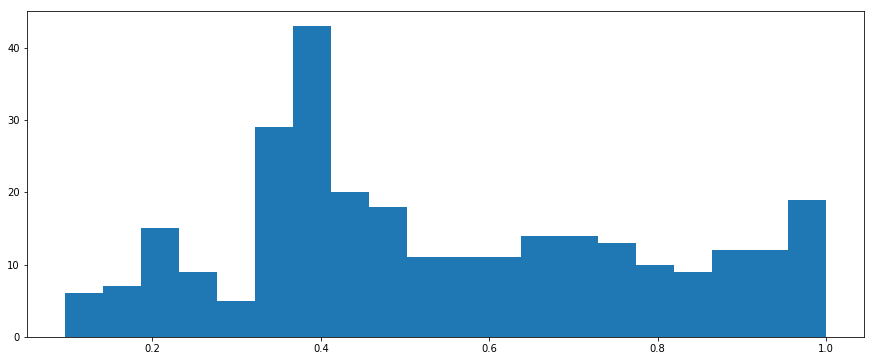

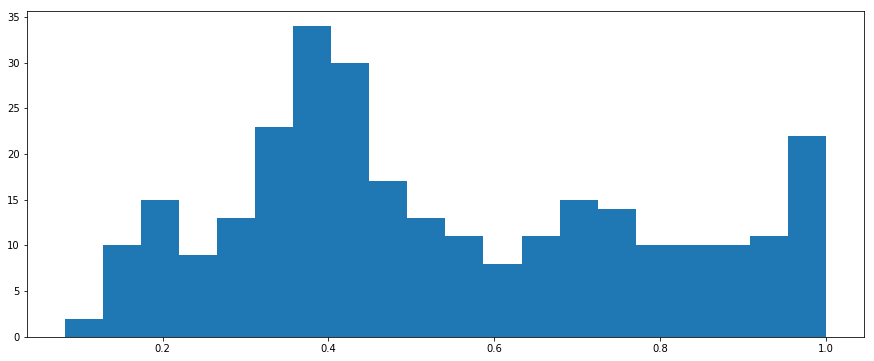

In [35]:

def priorities (y_true, y_pred):
    w = np.arange(1,0, -1./24) ** 2
    w = w / w.sum()
    w = w[:,None]
    W = K.variable(value = w)
    return K.dot( K.abs(y_pred-y_true), W)

batch = 1
seed = 11
# create and fit the LSTM network
model = create_model(rate=0.2)

np.random.seed(seed)
model.compile(loss=priorities, optimizer=RMSprop(lr=0.0002, rho=0.9, epsilon=1e-08, decay=0.0002))
model.fit(trainX, trainY, epochs=60, batch_size=60, verbose=2)
for i in range (30):
    if i % 10 == 9:
        model.fit(trainX, trainY, epochs=60, batch_size=60, verbose=2)
    else:
        model.fit(trainX, trainY, epochs=60, batch_size=60, verbose=3)
predict(model, total_days=1,day=11,delta=24)

cdf_matrix = predict(model, total_days=1,day=11,delta=1, show_graph=False)
for i in range (24):
    plt.hist(cdf_matrix[:,i],20)
    plt.show()